In [272]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import reading
import scipy.stats as st
import math
import yaml
import os
import numpy.lib.recfunctions as rfn
import scipy.signal as sg
import scipy.optimize as oz
import astropy.time
import astropy.coordinates
import astropy.units as u

In [23]:
def loaddriftcurves(dirname,pol,frequencies):
    #load driftcurve model files output by the LSL script driftcurve.py
    #pol is the polarization, either 'NS' of 'EW'
    #dirname is the path to the directory where the driftcurve data is stored
    #frequencies are frequencies of the model files to load, as specified in the file name
    #Returns a 2D array with dimensions of LST and frequency
    alldriftcurves=np.zeros((len(frequencies),144))
    for i,f in enumerate(frequencies):
        driftcurve = np.loadtxt(dirname+'driftcurve_ovro_'+pol+'_'+str(f)+'.00.txt')
        alldriftcurves[i]=driftcurve[:,1]
    lst=driftcurve[:,0]
    return lst,alldriftcurves


In [24]:
#Load the models
dirname='/home/kplant/model_driftcurves/'
frequencies=np.asarray(range(30,80))

#NS
pol='NS'
lsts, modelNSarray=loaddriftcurves(dirname,pol,frequencies)

#EW
pol='EW'
lsts, modelEWarray=loaddriftcurves(dirname,pol,frequencies)

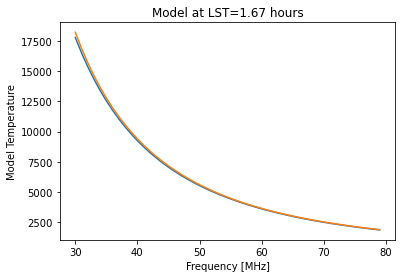

In [82]:
lstindex=10
plt.plot(frequencies,modelNSarray[:,lstindex],label='NS dipole')
plt.plot(frequencies,modelEWarray[:,lstindex],label='EW dipole')
lststring=str(round(lsts[10],2))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Model Temperature')
plt.title('Model at LST='+lststring+' hours')
plt.show()


In [44]:
# preliminary info for loading data
dataproductsdir='/lustre/kplant/2024October23-dataproducts/'
datadir='/lustre/kplant/2024October23/'
config=dataproductsdir+'config.yml'


with open(config, 'r') as file:
    configuration=yaml.safe_load(file)
#array_map_filename=configuration['array_map_filename'] 
array_map_filename='/home/kplant/lwa-cosmic-rays/array-map-5-22-2023.csv'
h=np.asarray(configuration['filter'])

lwa_df = reading.read_antpos()
namedict=build_mapping_dictionary(lwa_df)

array_map=pd.read_csv(array_map_filename)
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

fs= 196 #MHz
h=np.asarray(configuration['filter'])

In [17]:
#load the summary arrays for the events that passed the impulsive cut
filelist=[fname for fname in os.listdir(dataproductsdir) if (fname[:2]=='fi' and fname[-3:]=='npy')]
print(len(filelist))

arrays_to_merge=[]
for i in range(len(filelist)):
    #get the file name of the summary file and of the data file
    summaryfname=filelist[i]
    datafname=summaryfname[:-12]
    #load the summary array
    arr=np.load(dataproductsdir+summaryfname)
    #add this array to the list of arrays to merge
    arrays_to_merge.append(arr)
    
#merge all the arrays
impulsivesummary=np.concatenate(arrays_to_merge)

20


In [20]:
#Load some events
#Enter location of OVRO-LWA, to use for LST calculation
location = astropy.coordinates.EarthLocation.from_geodetic(lon=-118.2951*u.deg, lat=37.2317*u.deg, height=0*u.m)

#Calculate indices for a selection of events, so that this uses events from a range of LST but doesn't run on the whole dataset (for runtime reasons)
number_impulsive_events=len(impulsivesummary)
number_events_to_use=10
if number_events_to_use>=number_impulsive_events:
    indices=range(len(number_impulsive_events))
if number_events_to_use<number_impulsive_events:
    indices=np.linspace(0,number_impulsive_events-1,number_events_to_use,dtype=int)

#loop over the selection of events
for i in indices:
    datafname=impulsivesummary['datafname'][i]
    #get the timestamp and convert it to LST
    timestamp=impulsivesummary['timestamp'][i]
    unixtime=timestamp/(fs*1e6)
    timeobject = astropy.time.Time(unixtime, format='unix', location=location)
    lst = timeobject.sidereal_time('apparent').hour
    
    #load the data, calculate the per-antenna summary statistics, and flag antennas
    datafile=datadir+datafname
    index_in_file=impulsivesummary['index_in_file'][i]
    event_records=parsefile(datafile,start_ind=index_in_file,end_ind=704 )
    event_summary=summarize_signals(event_records,np.asarray(configuration['filter']),namedict,xdict,ydict,zdict)
    event_summary_flagged=flag_antennas(event_summary,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                        configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],1,
    configuration['known_bad_antennas'])[0]
    


In [40]:
print(lst)

5.713795473768939


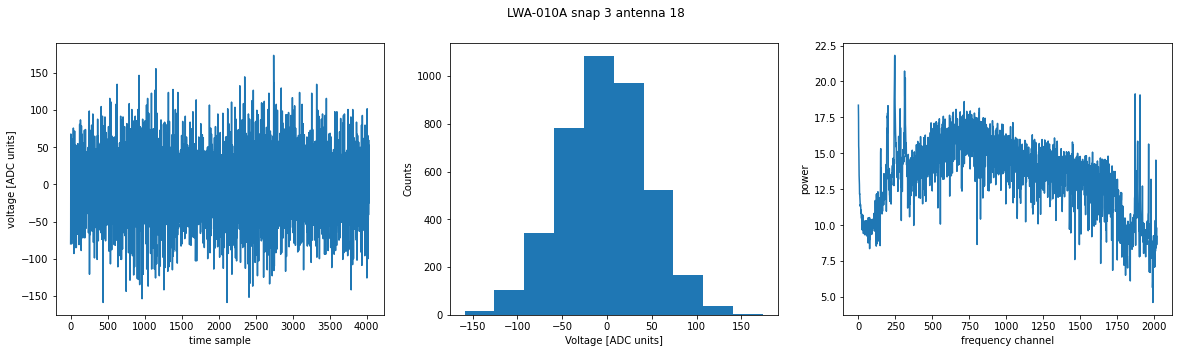

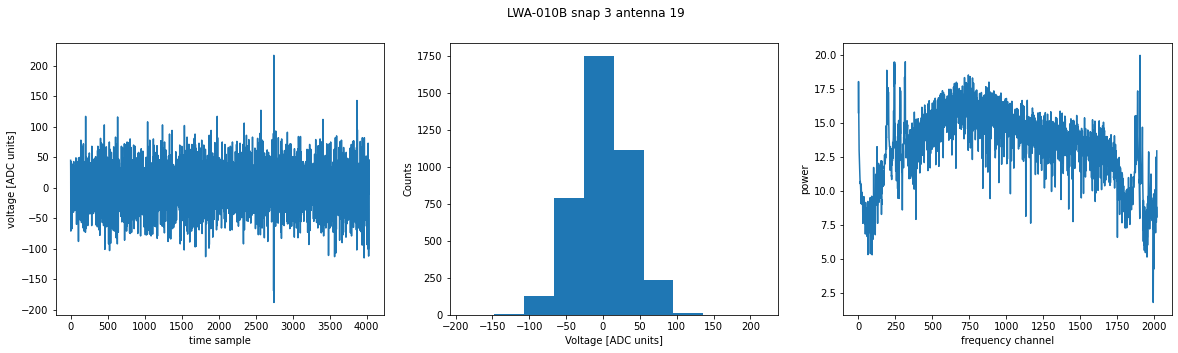

In [39]:
Filter=False
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        if type(Filter)==np.ndarray:
            timeseries=signal.convolve(timeseries,Filter,mode='valid')
        plt.figure(figsize=(20,5))
        plt.suptitle(antname + ' snap '+ str(s) + ' antenna ' + str(a))
            
        plt.subplot(131)
        plt.plot(timeseries)
        plt.xlabel('time sample')
        plt.ylabel('voltage [ADC units]')

        plt.subplot(132)
        plt.hist(timeseries)
        plt.xlabel('Voltage [ADC units]')
        plt.ylabel('Counts')

        plt.subplot(133)
        plt.xlabel('frequency channel')
        plt.ylabel('power')
        spec=np.fft.rfft(timeseries)
        plt.plot(np.log(np.square(np.abs(spec))))     


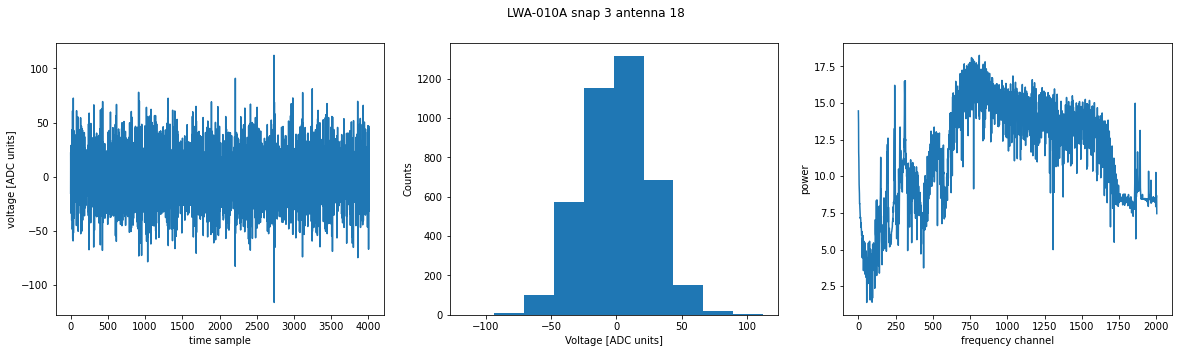

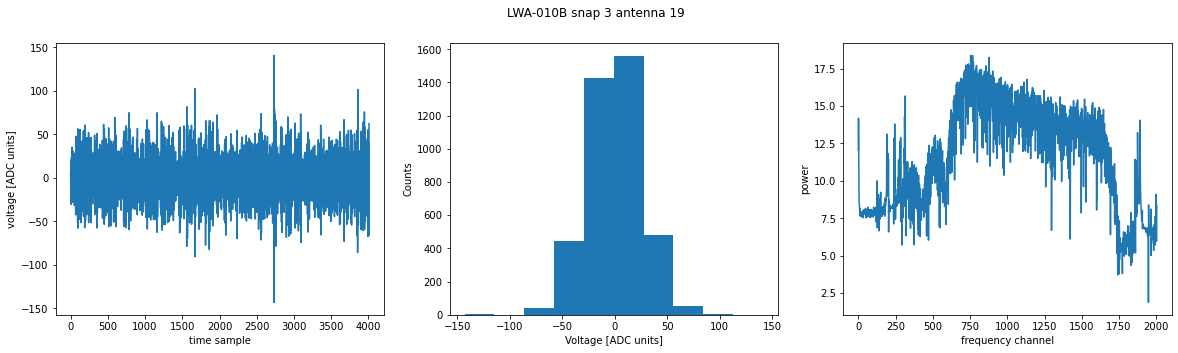

In [45]:
Filter=h
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        if type(Filter)==np.ndarray:
            timeseries=signal.convolve(timeseries,Filter,mode='valid')
        plt.figure(figsize=(20,5))
        plt.suptitle(antname + ' snap '+ str(s) + ' antenna ' + str(a))
            
        plt.subplot(131)
        plt.plot(timeseries)
        plt.xlabel('time sample')
        plt.ylabel('voltage [ADC units]')

        plt.subplot(132)
        plt.hist(timeseries)
        plt.xlabel('Voltage [ADC units]')
        plt.ylabel('Counts')

        plt.subplot(133)
        plt.xlabel('frequency channel')
        plt.ylabel('power')
        spec=np.fft.rfft(timeseries)
        plt.plot(np.log(np.square(np.abs(spec))))    

In [110]:
def indexfilterbank(f1,f2,bw):
    output=np.zeros((len(f2),len(f1)),dtype=np.bool)
    for i,f in enumerate(f2):
        output[i,:]=np.logical_and(f1>f-0.5*bw,f1<f+0.5*bw)
    return output

def filterbankaverage(spec,filterbankindices):
    output=np.zeros(len(filterbankindices))
    for i in range(len(filterbankindices)):
        output[i]=np.mean(spec[filterbankindices[i]])
    return output


    

34
5.682576718386262


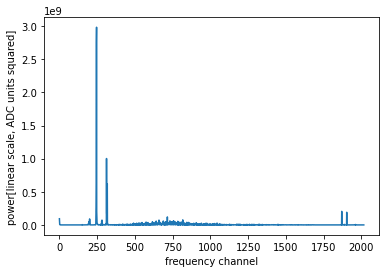

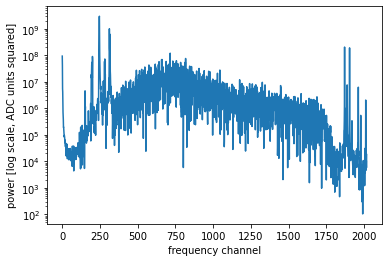

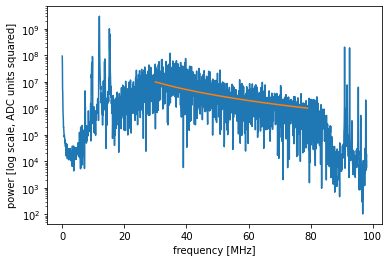

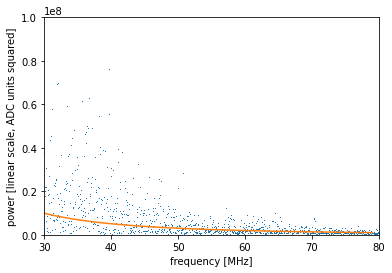

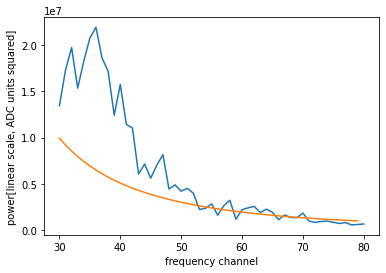

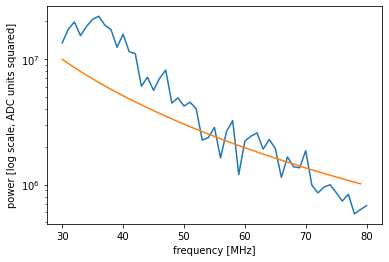

In [109]:
lstindex=np.argmin(np.abs(lsts-lst))
print(lstindex)
print(lsts[lstindex])



antennas=['LWA-010A']
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)
        
        plt.figure()
        #plt.title(antname + ' snap '+ str(s) + ' antenna ' + str(a))
        plt.xlabel('frequency channel')
        plt.ylabel('power[linear scale, ADC units squared]')
        plt.plot(np.square(np.abs(spec)))
        
        plt.figure()
        plt.xlabel('frequency channel')
        plt.ylabel('power [log scale, ADC units squared]')
        plt.semilogy(np.square(np.abs(spec))) 
        
        plt.figure()    
        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [log scale, ADC units squared]')
        plt.semilogy(f,np.square(np.abs(spec))) 
        plt.semilogy(frequencies,6e2*modelNSarray[:,lstindex],label='NS dipole')

        plt.figure()    
        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [linear scale, ADC units squared]')
        spec=np.fft.rfft(timeseries)
        f=np.linspace(0,fs/2,len(spec))
        plt.plot(f,np.square(np.abs(spec)),',') 
        plt.plot(frequencies,6e2*modelNSarray[:,lstindex],label='NS dipole')
        plt.xlim(30,80)
        plt.ylim(0,1e8)
        
        
        plt.figure()
        plt.xlabel('frequency channel')
        plt.ylabel('power[linear scale, ADC units squared]')
        plt.plot(fnew,smoothspec)
        plt.plot(frequencies,6e2*modelNSarray[:,lstindex],label='NS dipole')
        
        plt.figure()    
        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [log scale, ADC units squared]')
        plt.semilogy(fnew,smoothspec) 
        plt.semilogy(frequencies,6e2*modelNSarray[:,lstindex],label='NS dipole')

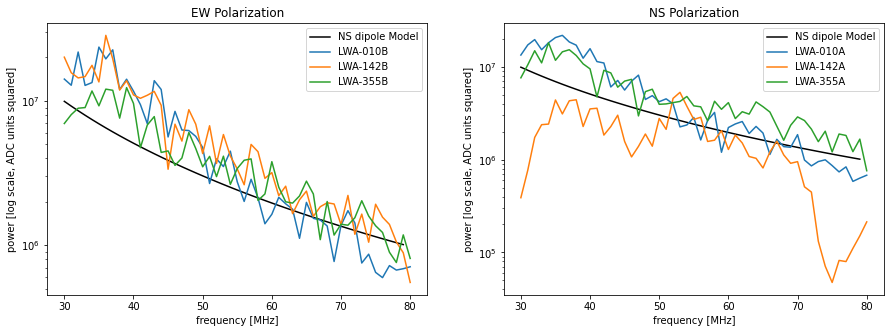

In [115]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('EW Polarization')
antennas=['LWA-010B','LWA-142B','LWA-355B']
plt.semilogy(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [log scale, ADC units squared]')
        plt.semilogy(fnew,smoothspec,label=antname) 
plt.legend()

plt.subplot(122)
plt.title('NS Polarization')
antennas=['LWA-010A','LWA-142A','LWA-355A']
plt.semilogy(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [log scale, ADC units squared]')
        plt.semilogy(fnew,smoothspec,label=antname) 
plt.legend()
plt.show()

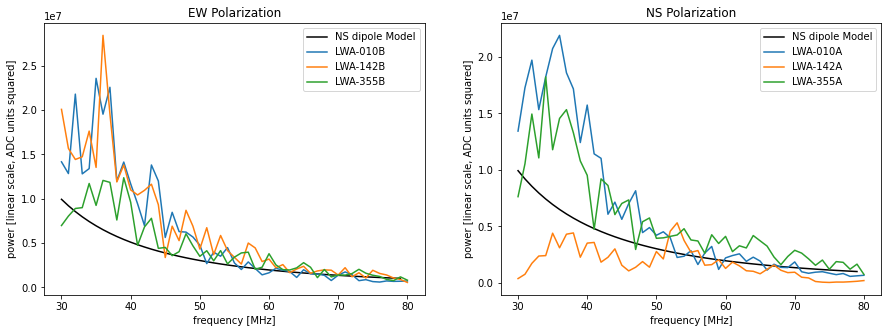

In [117]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('EW Polarization')
antennas=['LWA-010B','LWA-142B','LWA-355B']
plt.plot(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [linear scale, ADC units squared]')
        plt.plot(fnew,smoothspec,label=antname) 
plt.legend()

plt.subplot(122)
plt.title('NS Polarization')
antennas=['LWA-010A','LWA-142A','LWA-355A']
plt.plot(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [linear scale, ADC units squared]')
        plt.plot(fnew,smoothspec,label=antname) 
plt.legend()
plt.show()

2017
1001
1001


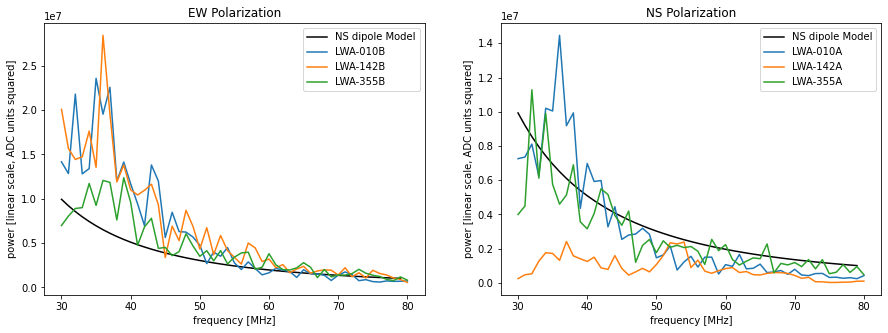

In [119]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('EW Polarization')
antennas=['LWA-010B','LWA-142B','LWA-355B']
plt.plot(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries)
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [linear scale, ADC units squared]')
        plt.plot(fnew,smoothspec,label=antname) 
plt.legend()

plt.subplot(122)
plt.title('NS Polarization')
antennas=['LWA-010A','LWA-142A','LWA-355A']
plt.plot(frequencies,6e2*modelNSarray[:,lstindex],'k',label='NS dipole Model')
for record in event_records:
    s=record['board_id']
    a=packet_ant_id_2_snap_input(record['antenna_id'])
    antname=mapping.snap2_to_antpol(s,a)
    if antname in antennas:
        timeseries=record['data']
        spec=np.fft.rfft(timeseries[:2000])
        print(len(powerspec))
        powerspec=np.square(np.abs(spec))
        f=np.linspace(0,fs/2,len(powerspec))
        fnew=np.linspace(30,80,51)
        filterbankindices=indexfilterbank(f,fnew,1)
        smoothspec=filterbankaverage(powerspec,filterbankindices)

        plt.xlabel('frequency [MHz]')
        plt.ylabel('power [linear scale, ADC units squared]')
        plt.plot(fnew,smoothspec,label=antname) 
plt.legend()
plt.show()

In [152]:
t1=time.time()
#This takes a while to run for thousands of events
#Enter location of OVRO-LWA, to use for LST calculation
location = astropy.coordinates.EarthLocation.from_geodetic(lon=-118.2951*u.deg, lat=37.2317*u.deg, height=0*u.m)

#initialize the dictionary to hold the results
specdictionary={}


#Calculate indices for a selection of events, so that this uses events from a range of LST but doesn't run on the whole dataset (for runtime reasons)
number_impulsive_events=len(impulsivesummary)
number_events_to_use=2000
if number_events_to_use>=number_impulsive_events:
    indices=range(len(number_impulsive_events))
if number_events_to_use<number_impulsive_events:
    indices=np.linspace(0,number_impulsive_events-1,number_events_to_use,dtype=int)

#Set up frequency arrays
ntimesamp=2000
f=np.linspace(0,fs/2,(ntimesamp//2)+1) #These are the frequencies corresponding to the dft of the first 2000 samples of the timeseries
fnew=np.linspace(30,80,51) #These are the frequencies of the 1 MHz wide channels that the spectrum will be smoothed to
filterbankindices=indexfilterbank(f,fnew,1) #these are the indices to use to smooth the spectrum to the 1MHz channels

#loop over the selection of events
for i in indices:
    datafname=impulsivesummary['datafname'][i]
    #get the timestamp and convert it to LST
    timestamp=impulsivesummary['timestamp'][i]
    unixtime=timestamp/(fs*1e6)
    timeobject = astropy.time.Time(unixtime, format='unix', location=location)
    lst = timeobject.sidereal_time('apparent').hour
    
    #load the data, calculate the per-antenna summary statistics, and flag antennas
    datafile=datadir+datafname
    index_in_file=impulsivesummary['index_in_file'][i]
    event_records=parsefile(datafile,start_ind=index_in_file,end_ind=704 )
    event_summary=summarize_signals(event_records,np.asarray(configuration['filter']),namedict,xdict,ydict,zdict)
    event_summary_flagged=flag_antennas(event_summary,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                        configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],1,
    configuration['known_bad_antennas'])[0]
 
    #make a list of the good antennas for this event
    good_antennas=[event_summary_flagged[a]['antname']+event_summary_flagged[a]['pol'] for a in range(len(event_summary_flagged))]
    
    #loop through per-antenna records
    for record in event_records:
        s=record['board_id']
        a=packet_ant_id_2_snap_input(record['antenna_id'])
        antname=mapping.snap2_to_antpol(s,a)
        if antname in good_antennas:
            timeseries=record['data']
            spec=np.fft.rfft(timeseries[:ntimesamp])
            powerspec=np.square(np.abs(spec))
            smoothspec=filterbankaverage(powerspec,filterbankindices)
            #check if the antenna already has an entry. 
            #If this is the first event for which the antenna was not flagged, make an entry.
            if antname not in specdictionary.keys():
                newentry={}
                newentry['spec']=[]
                newentry['lst']=[]
                specdictionary[antname]=newentry
            #Add the lst and the spectrum to the appropriate entry in the appropriate dictionary.
            #These are stored as lists that get appended to, instead of pre-allocated arrays, because not every antenna will be present in the flagged summary array for every event
            specdictionary[antname]['lst'].append(lst)
            specdictionary[antname]['spec'].append(smoothspec) 
    
#convert to arrays instead of lists
for k in specdictionary.keys():
    specdictionary[k]['lst']=np.asarray(specdictionary[k]['lst'])
    specdictionary[k]['spec']=np.asarray(specdictionary[k]['spec'])

t2=time.time()
print(t2-t1)

2502.8977868556976


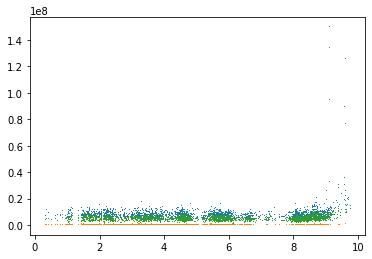

In [351]:
selectantennasA=['LWA-010A','LWA-142A','LWA-355A']
for a in selectantennasA:
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec']
    
    #plt.plot(fnew,spectra[1000])
    plt.plot(lst,spectra[:,0],',')



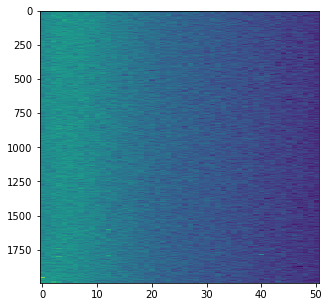

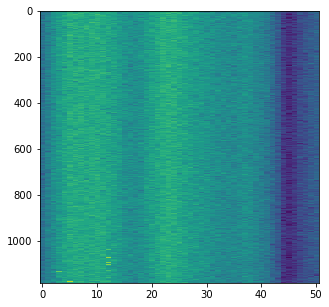

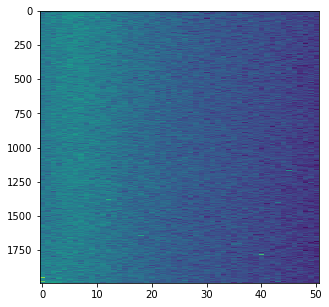

In [352]:
selectantennasA=['LWA-010A','LWA-142A','LWA-355A']
for a in selectantennasA:
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    plt.figure(figsize=(5,5))
    plt.imshow(np.log10(spectra_ordered),aspect='auto',interpolation='none')

    

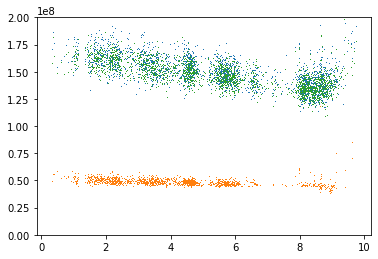

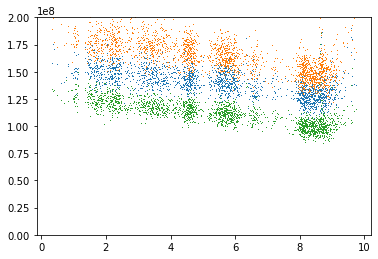

In [353]:
selectantennasA=['LWA-010A','LWA-142A','LWA-355A']
for a in selectantennasA:
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    plt.plot(lst[sorted_indices],np.sum(spectra_ordered,1),',')
    plt.ylim(0,2e8)
    
plt.figure()
selectantennas=['LWA-010B','LWA-142B','LWA-355B']
for a in selectantennas:
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    plt.plot(lst[sorted_indices],np.sum(spectra_ordered,1),',')
    plt.ylim(0,2e8)
    

(array([1.0174e+05, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.01658531e+05, 7.35382566e+07, 1.46974855e+08, 2.20411453e+08,
        2.93848051e+08, 3.67284649e+08, 4.40721247e+08, 5.14157845e+08,
        5.87594443e+08, 6.61031041e+08, 7.34467639e+08]),
 <BarContainer object of 10 artists>)

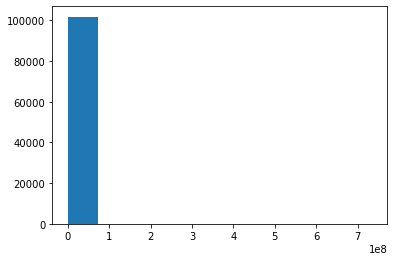

In [354]:
plt.hist(spectra.copy().flatten())

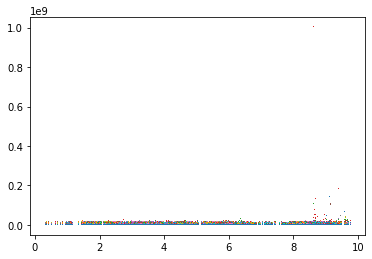

In [355]:
#plot a timeseries for each channel
plt.figure()
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    for i,freq in enumerate(fnew):
        plt.plot(lst[sorted_indices],spectra_ordered[:,i],',')


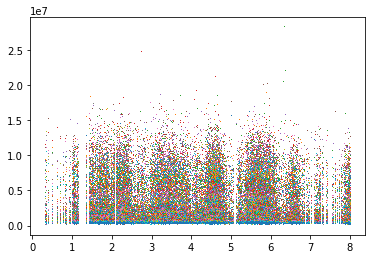

In [356]:
#same, but select nighttime data only (lst<8)
plt.figure()
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_select=lst_sorted[lst_sorted<8]
    spectra_select=spectra_ordered[lst_sorted<8]
    for i,freq in enumerate(fnew):
        plt.plot(lst_select,spectra_select[:,i],',')

/opt/devel/kplant/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


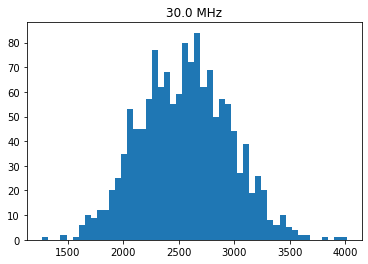

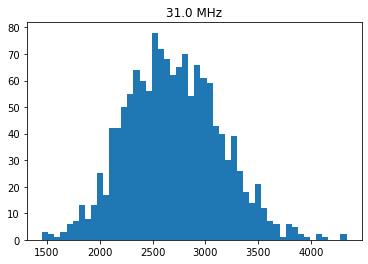

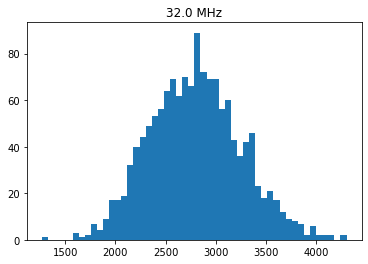

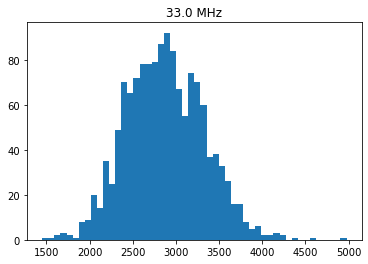

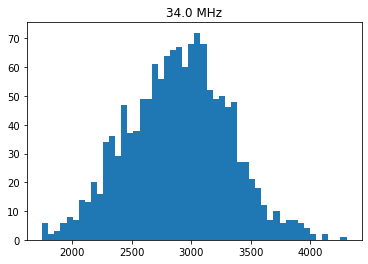

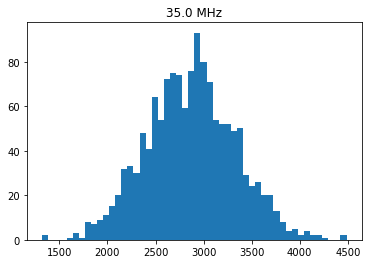

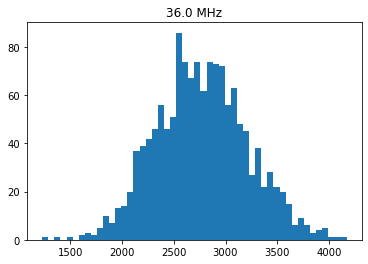

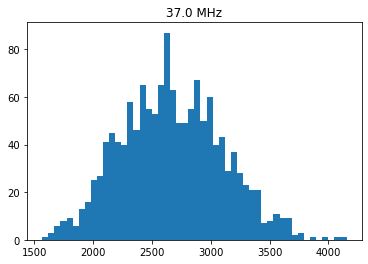

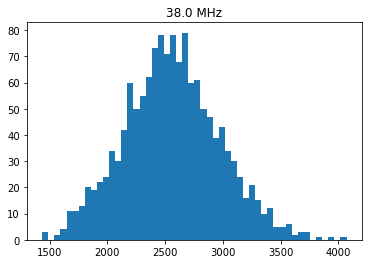

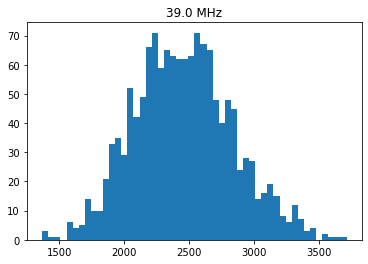

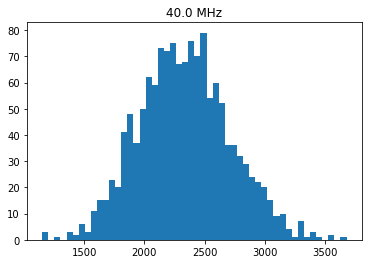

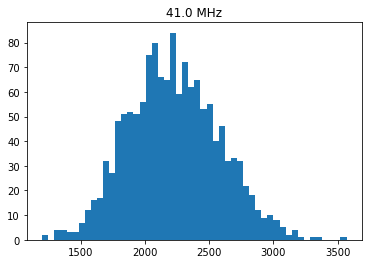

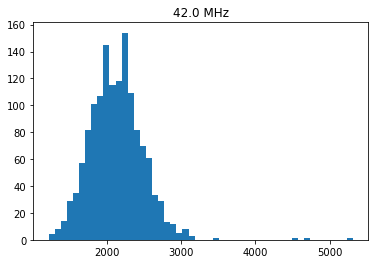

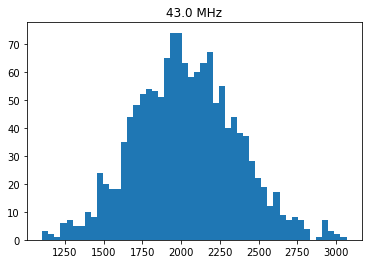

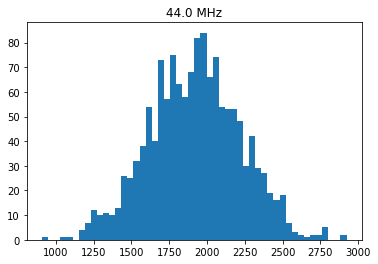

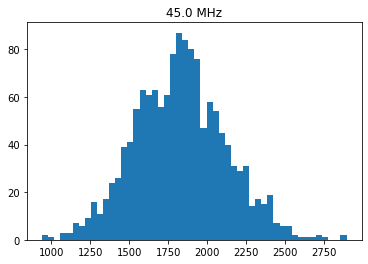

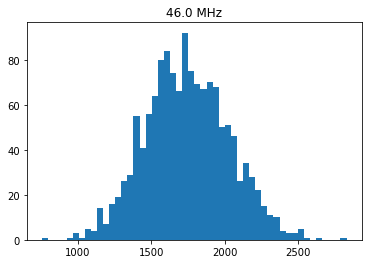

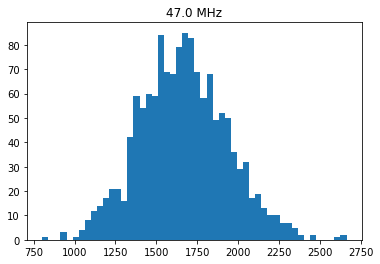

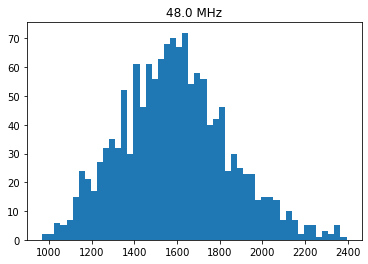

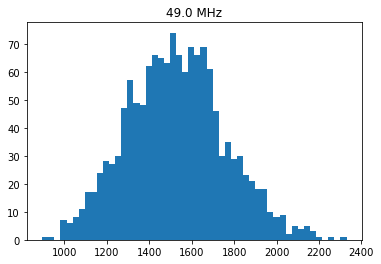

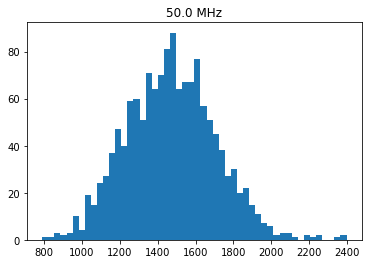

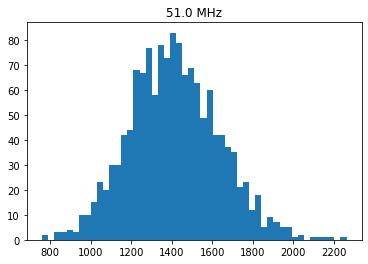

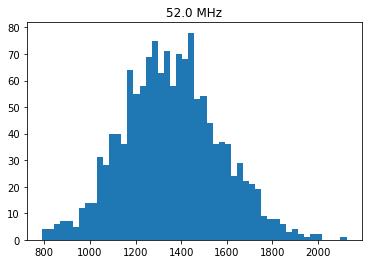

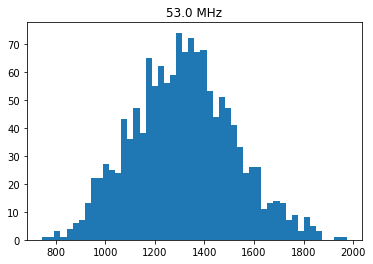

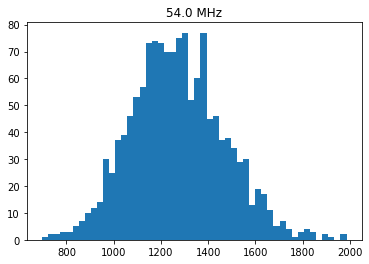

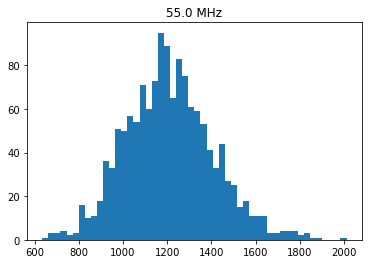

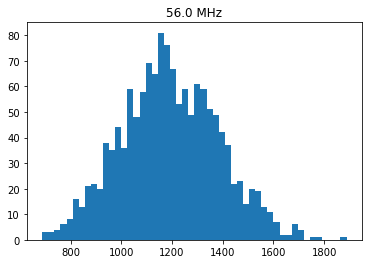

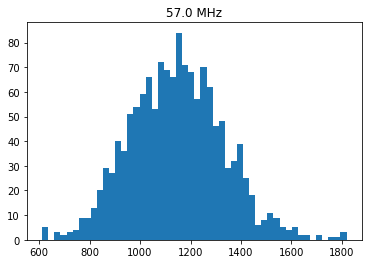

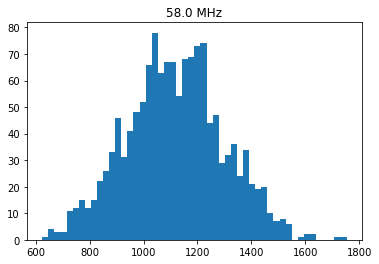

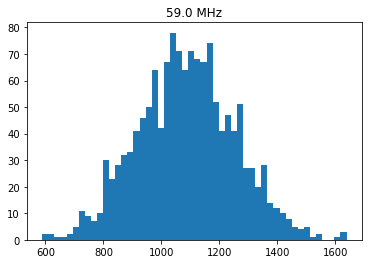

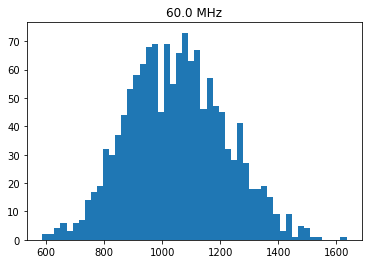

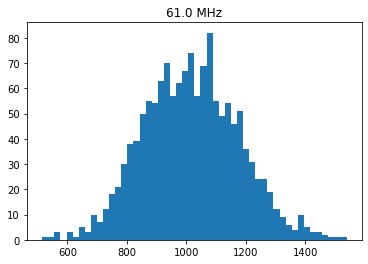

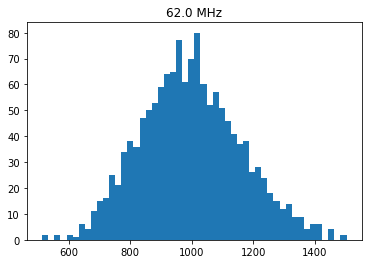

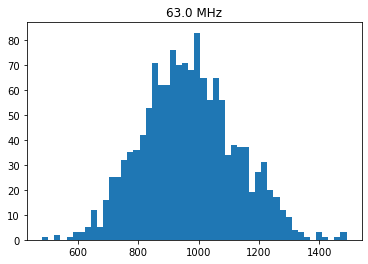

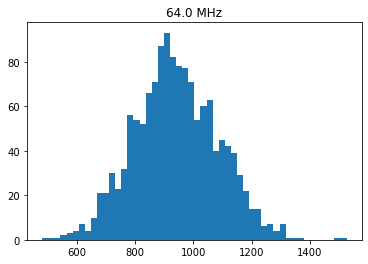

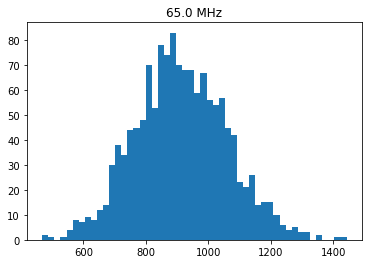

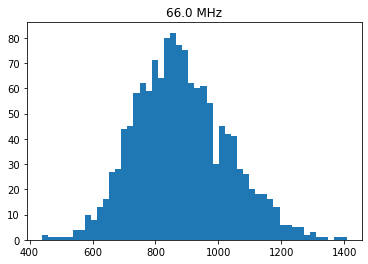

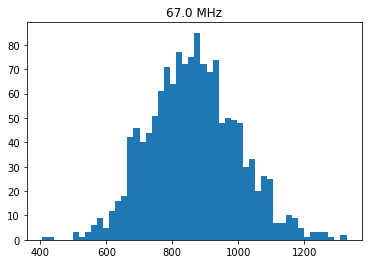

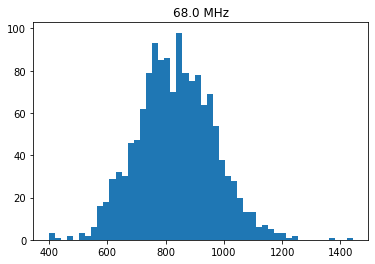

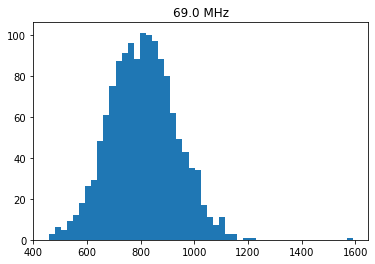

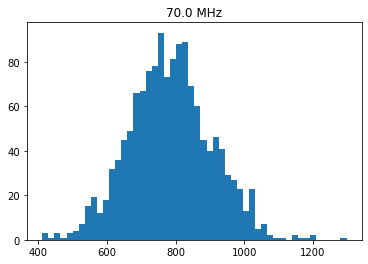

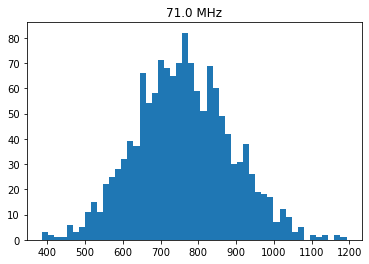

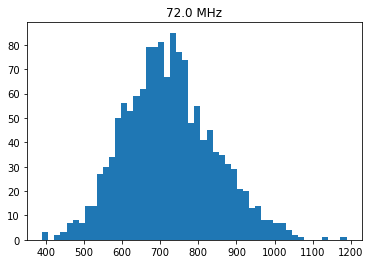

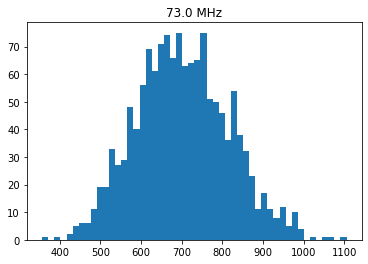

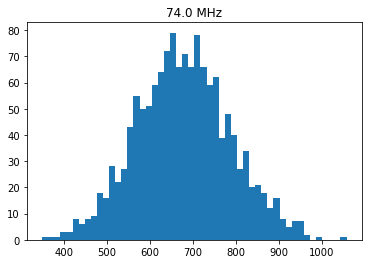

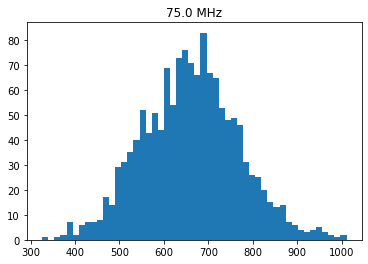

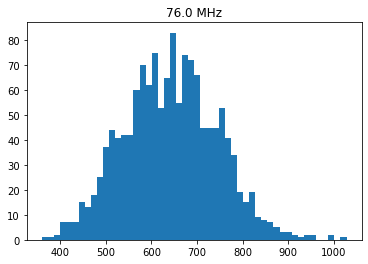

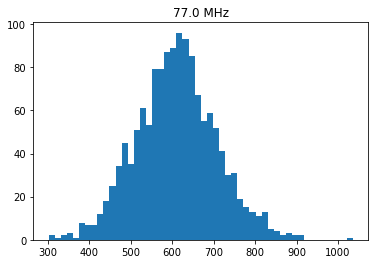

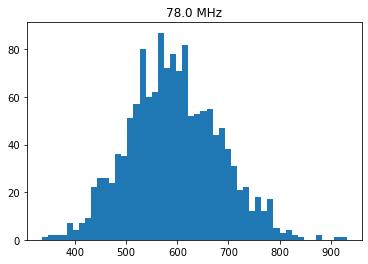

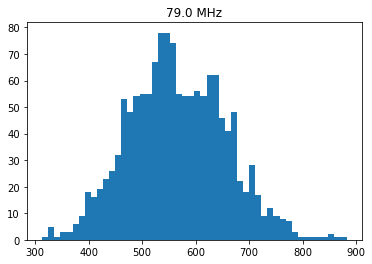

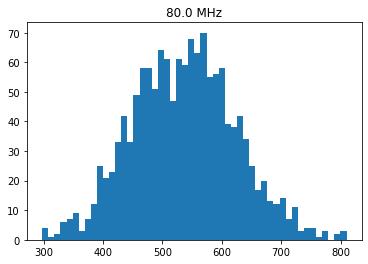

In [357]:
#look at the distribution of the SQUARE ROOT of the power, in each channel
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_select=lst_sorted[lst_sorted<8]
    spectra_select=spectra_ordered[lst_sorted<8]

    for i,freq in enumerate(fnew):
        plt.figure()
        plt.title(str(freq)+' MHz')
        plt.hist(np.sqrt(spectra_select[:,i]),50)

/opt/devel/kplant/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


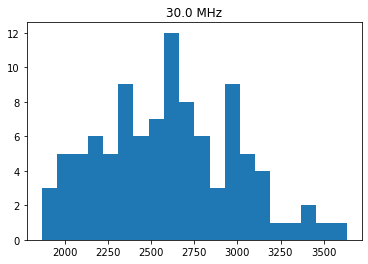

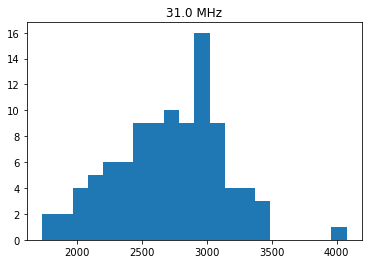

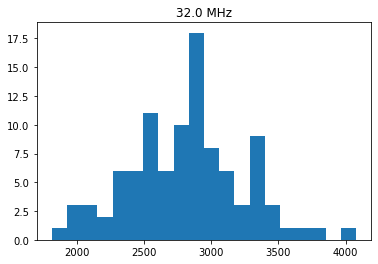

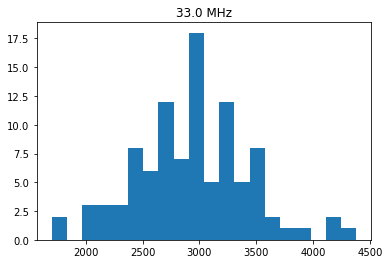

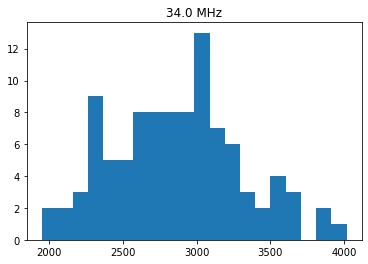

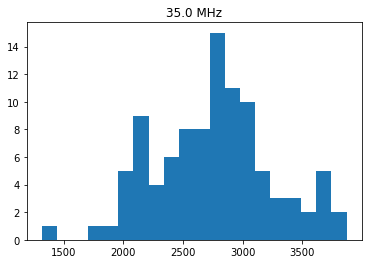

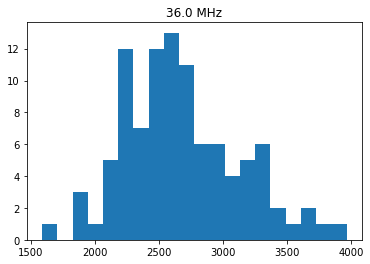

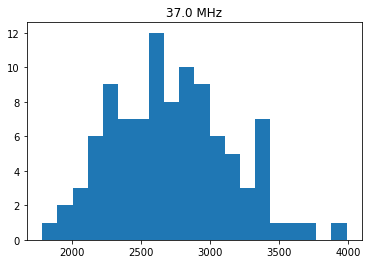

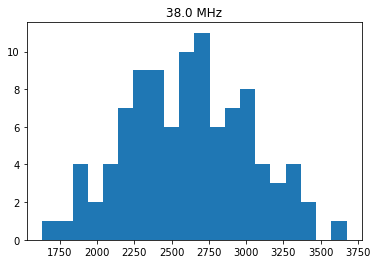

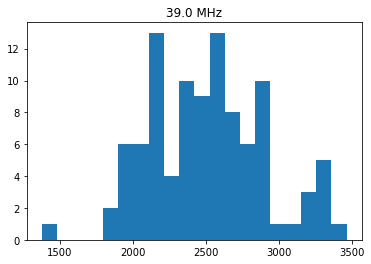

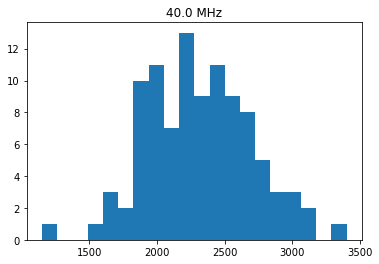

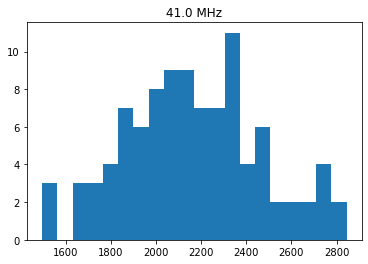

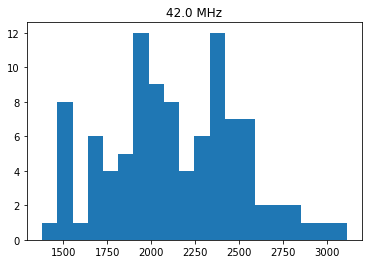

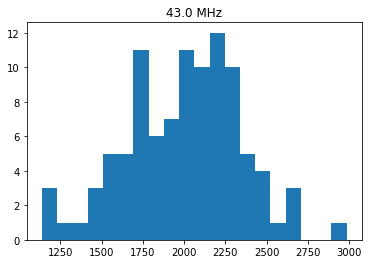

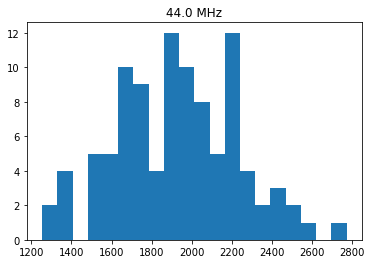

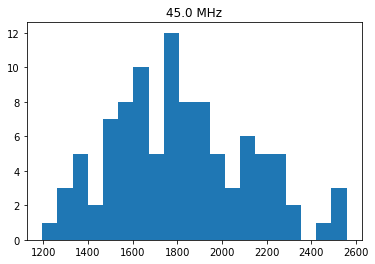

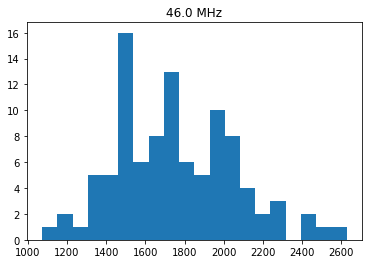

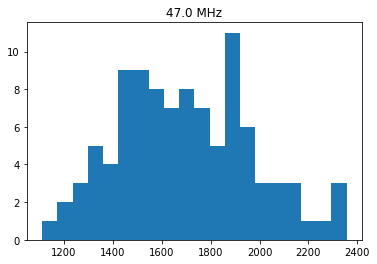

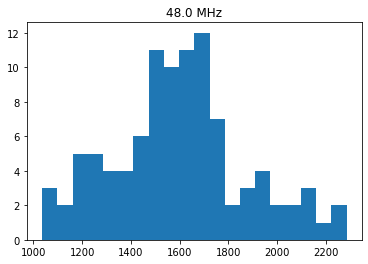

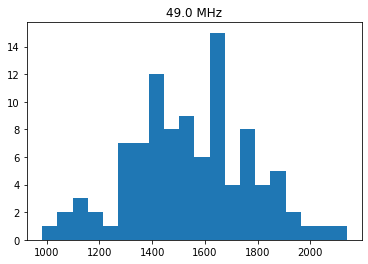

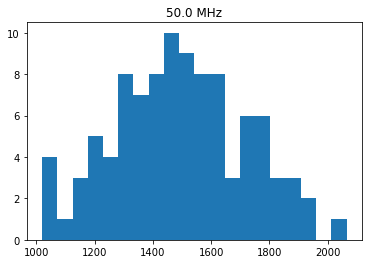

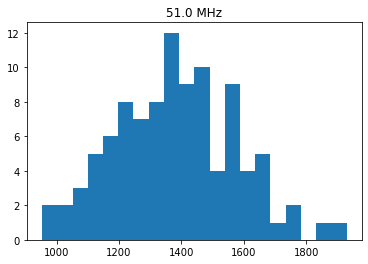

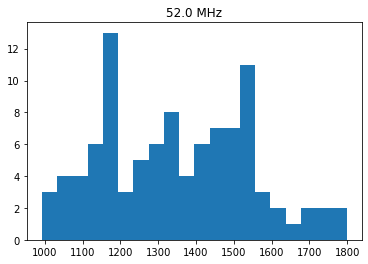

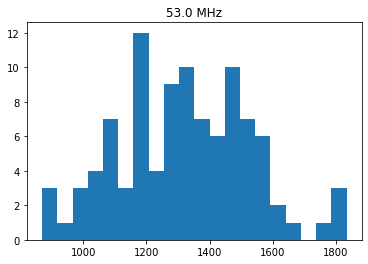

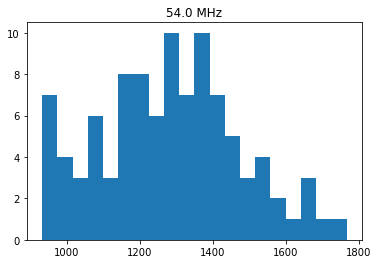

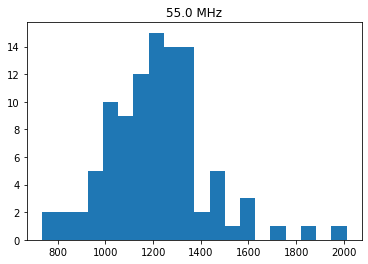

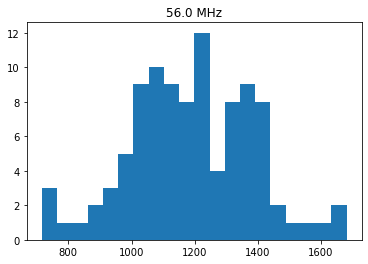

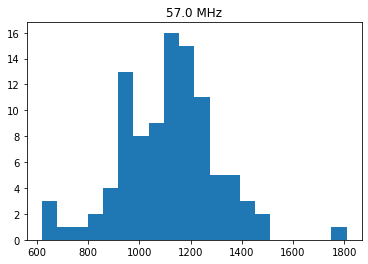

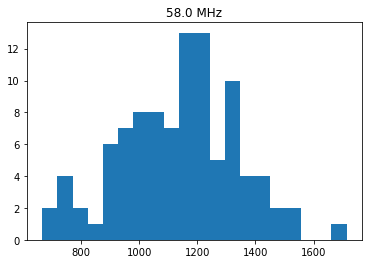

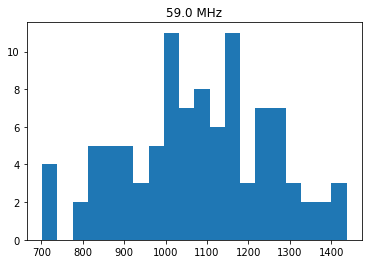

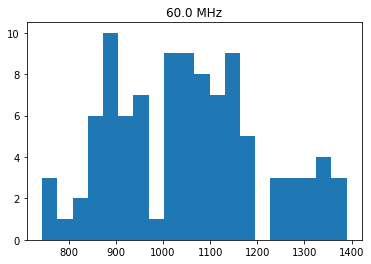

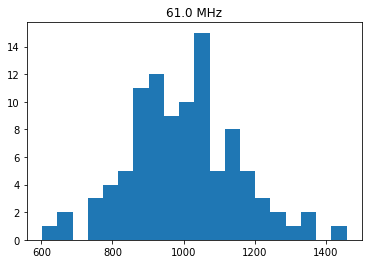

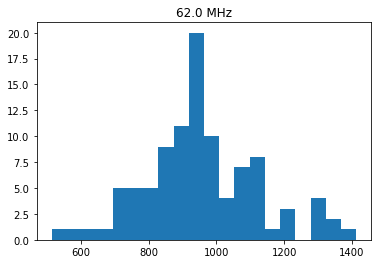

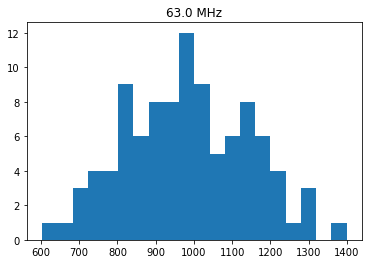

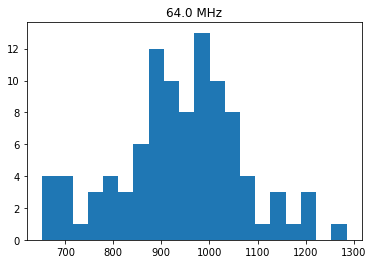

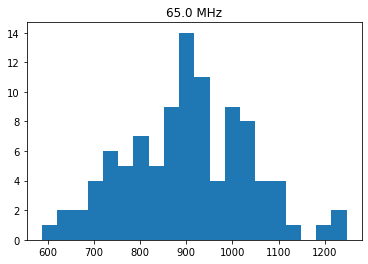

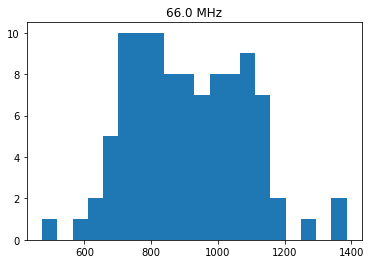

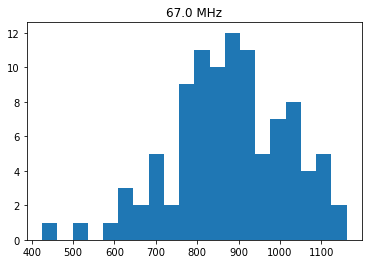

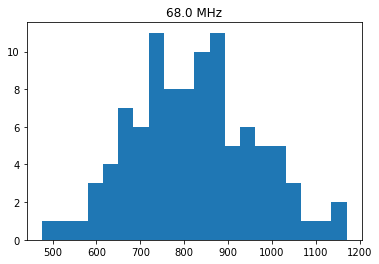

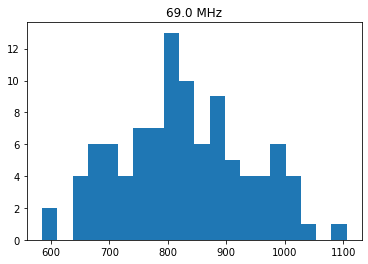

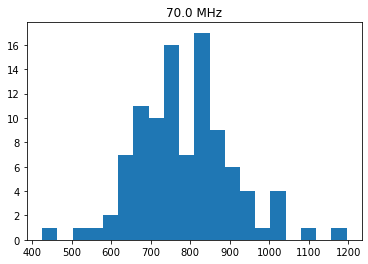

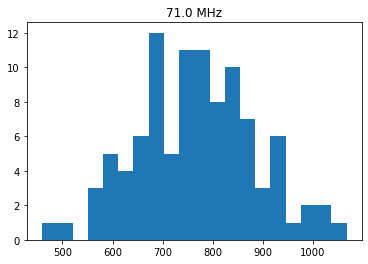

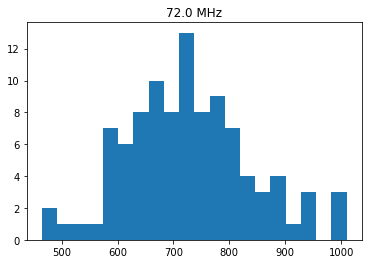

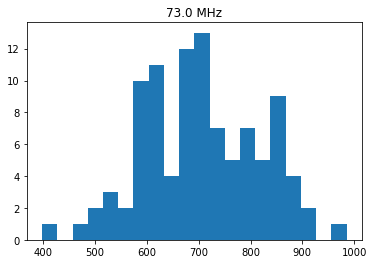

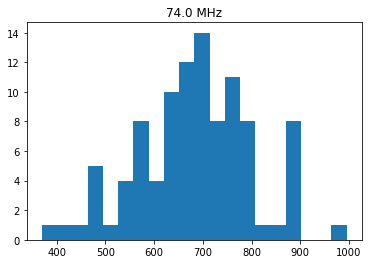

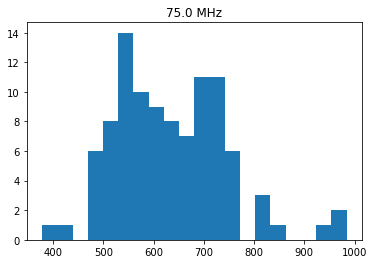

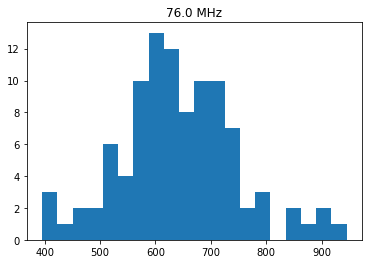

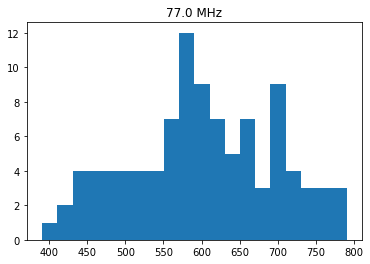

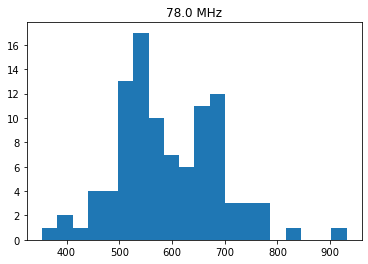

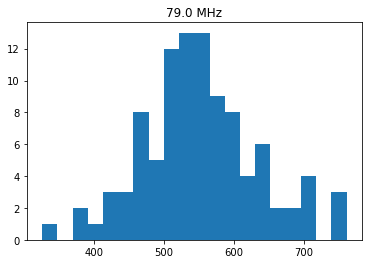

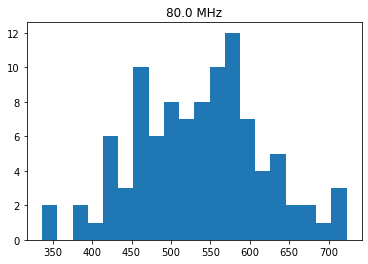

In [358]:
#look at that same distribution of the SQUARE ROOT of the power, in each channel, constrained to a narrower time window (so the galaxy won't have changed as much)
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_indices=np.logical_and(lst_sorted>4,lst_sorted<4.5)
    lst_select=lst_sorted[lst_indices]
    spectra_select=spectra_ordered[lst_indices]

    for i,freq in enumerate(fnew):
        plt.figure()
        plt.title(str(freq)+' MHz')
        plt.hist(np.sqrt(spectra_select[:,i]),20)

/opt/devel/kplant/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


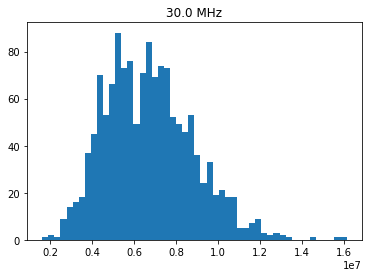

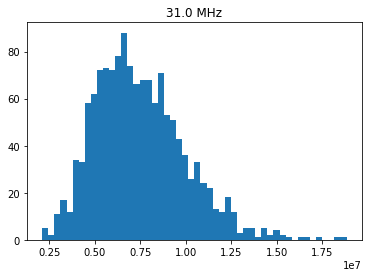

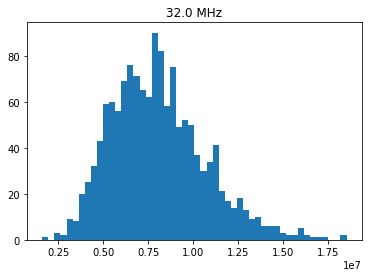

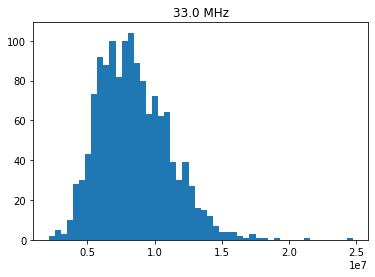

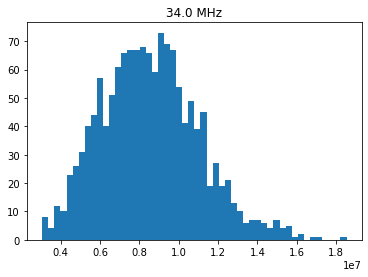

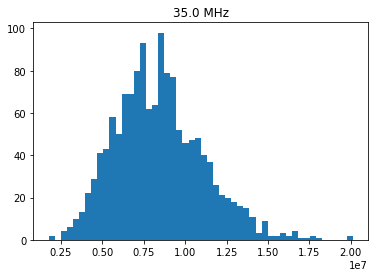

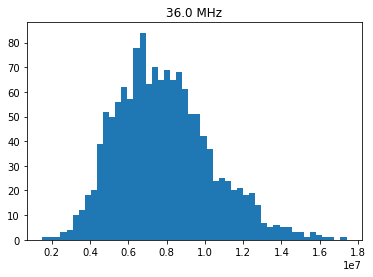

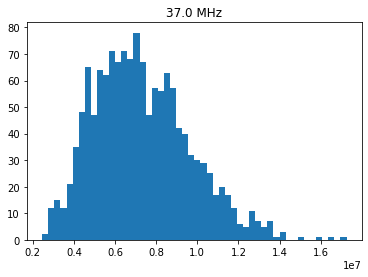

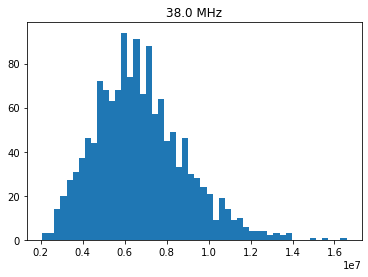

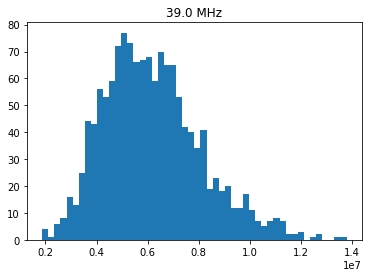

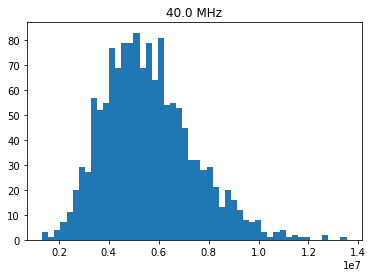

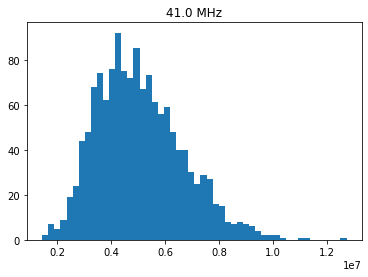

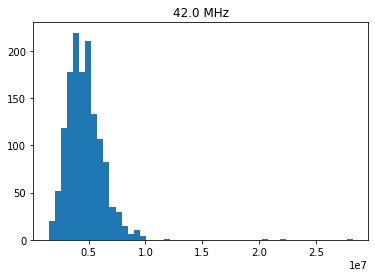

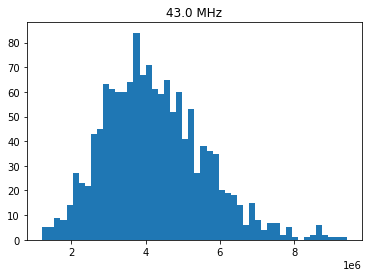

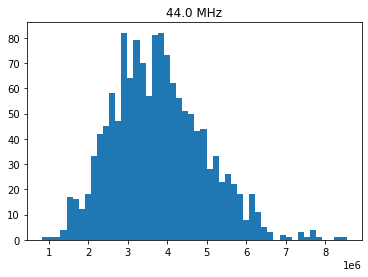

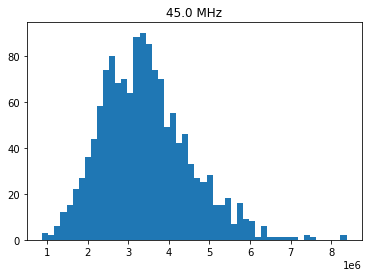

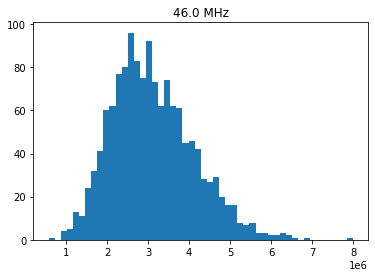

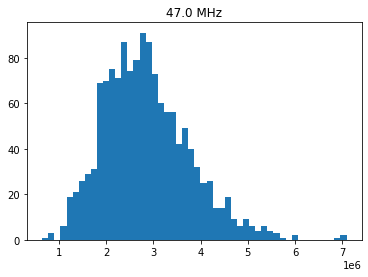

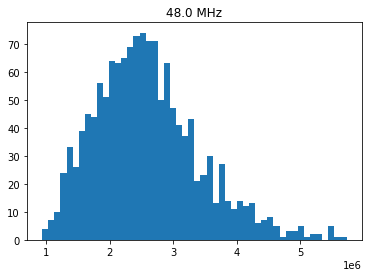

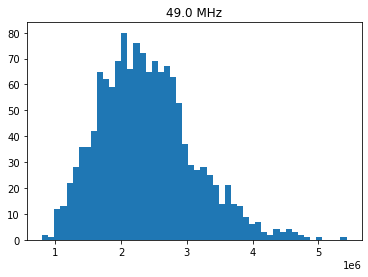

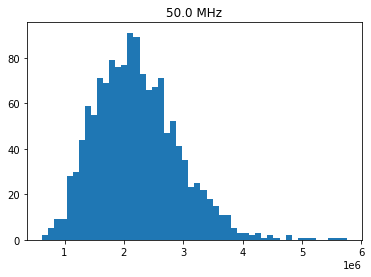

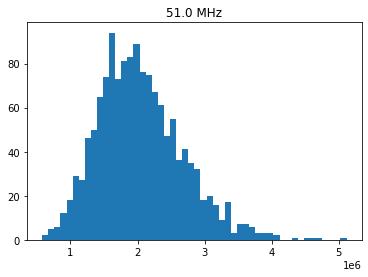

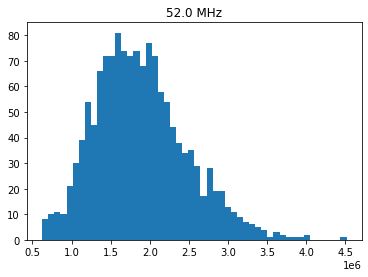

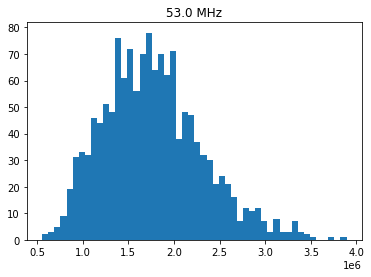

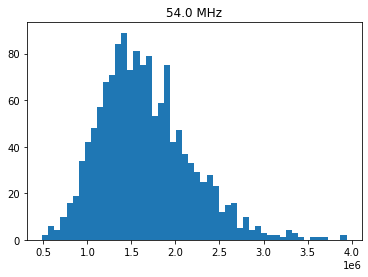

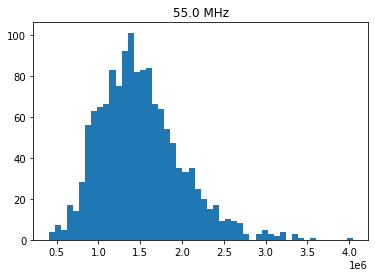

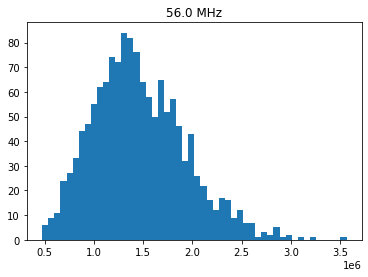

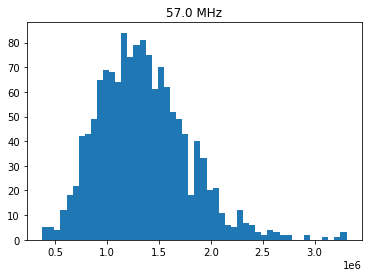

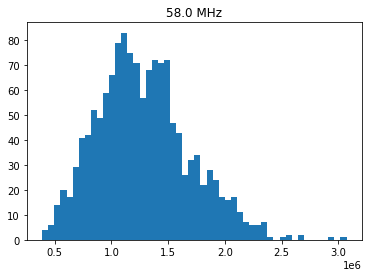

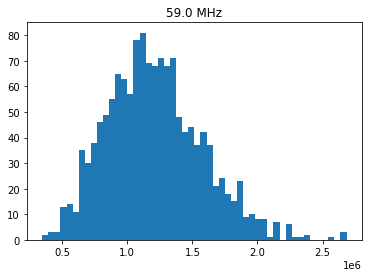

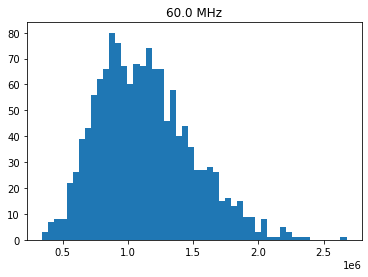

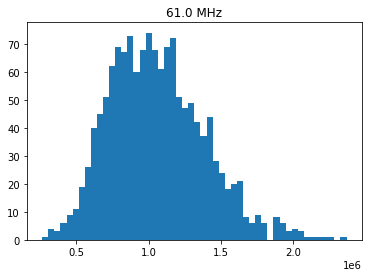

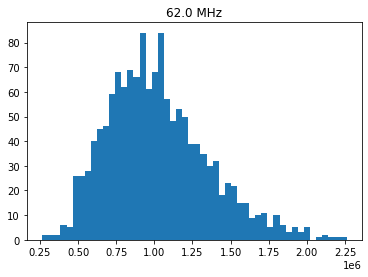

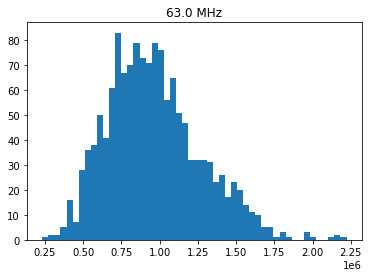

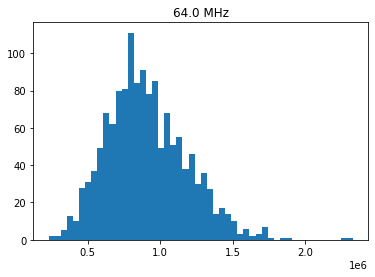

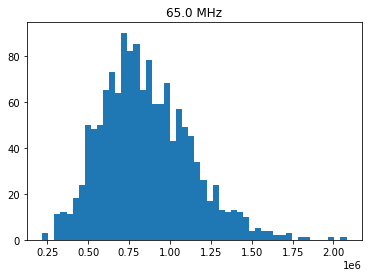

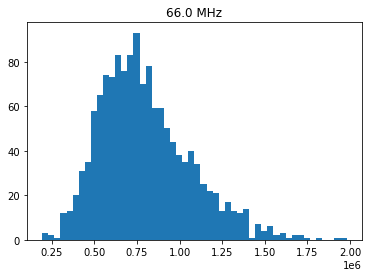

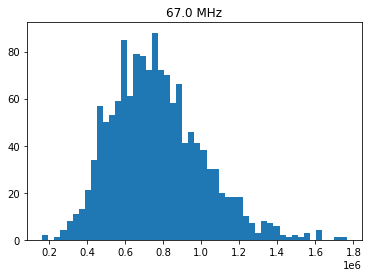

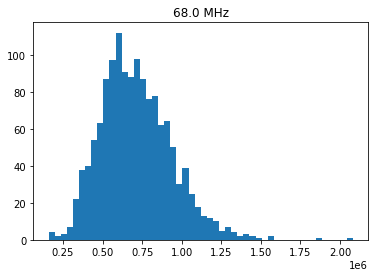

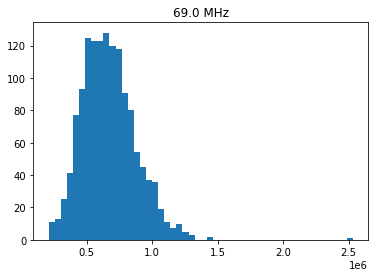

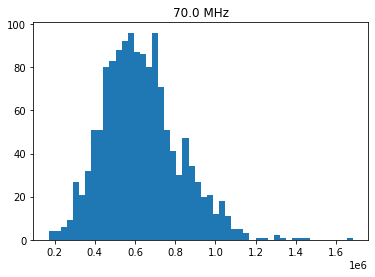

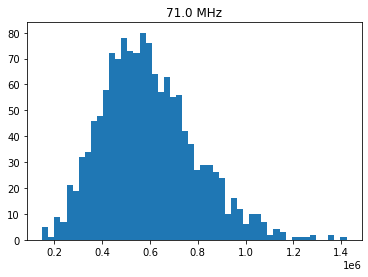

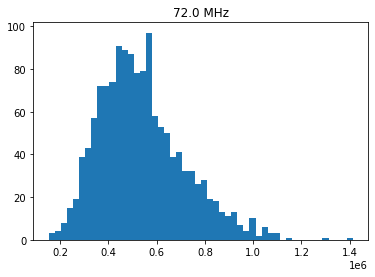

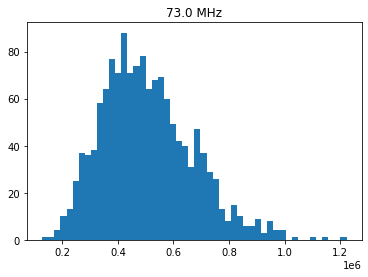

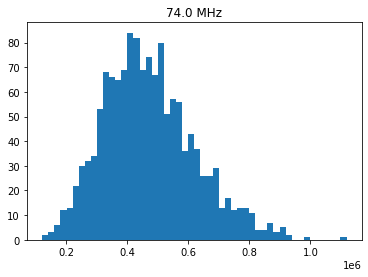

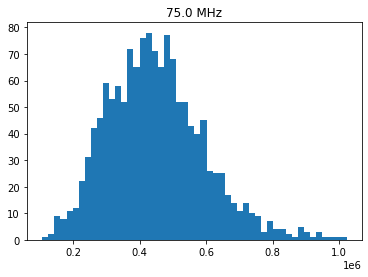

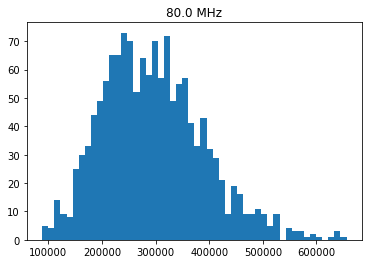

In [359]:
#look at the distribution of the power itself, in each channel
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_select=lst_sorted[lst_sorted<8]
    spectra_select=spectra_ordered[lst_sorted<8]

    for i,freq in enumerate(fnew):
        plt.figure()
        plt.title(str(freq)+' MHz')
        plt.hist(spectra_select[:,i],50)

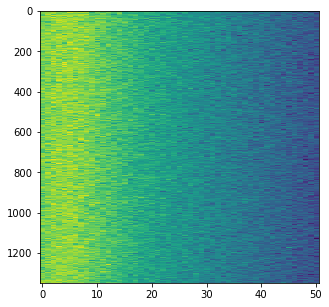

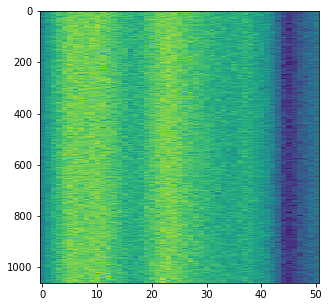

In [360]:
selectantennasA=['LWA-010A','LWA-142A','LWA-355A']
for a in selectantennasA:
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    lst_sorted=lst[sorted_indices]
    spectra_ordered=spectra[sorted_indices]
    plt.figure(figsize=(5,5))
    plt.imshow(np.log10(spectra_ordered[lst_sorted<7.5]),aspect='auto',interpolation='none')

    

Notes:
The individual channels do look gaussian-ish by eye when including the full span of time, but not on shorter timescales. Power does look Rayleigh distributed.

I could do some RFI flagging later, but it looks like a small number of samples.

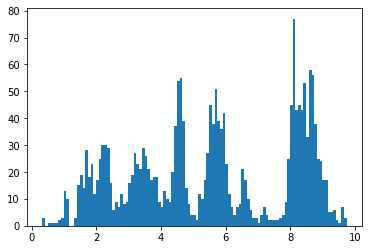

In [361]:
plt.hist(lst,int((lst.max()-lst.min())*(60/5)))
plt.show()

/opt/devel/kplant/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


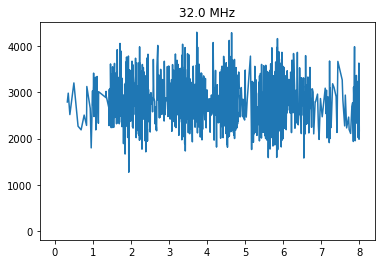

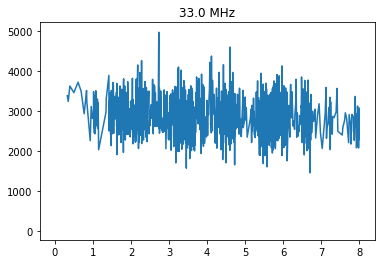

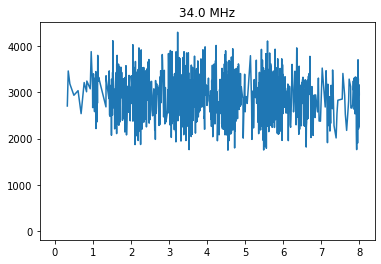

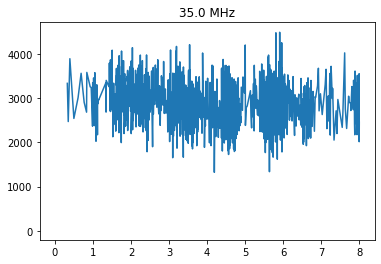

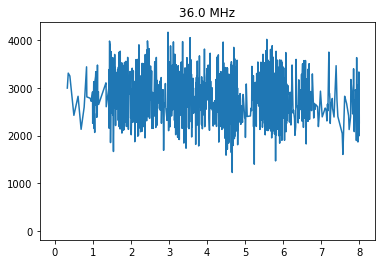

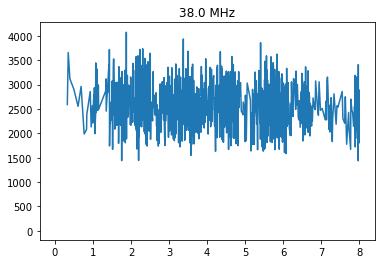

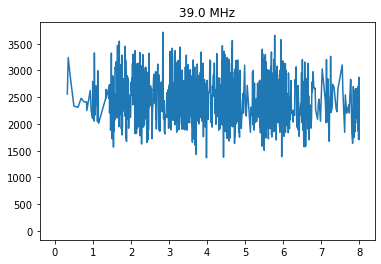

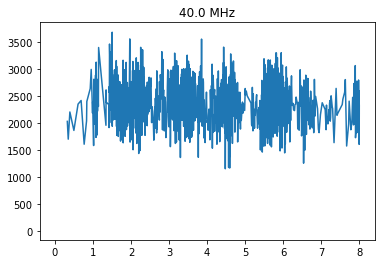

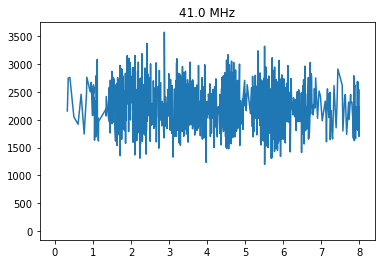

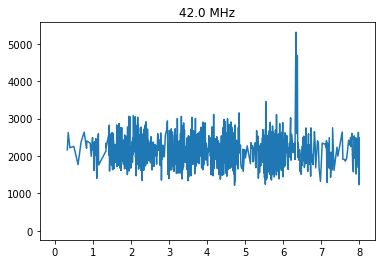

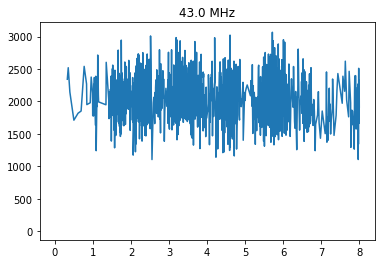

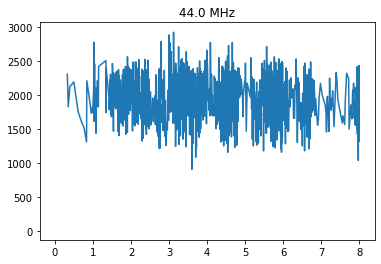

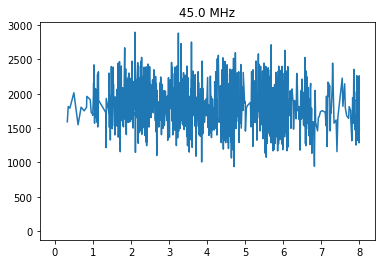

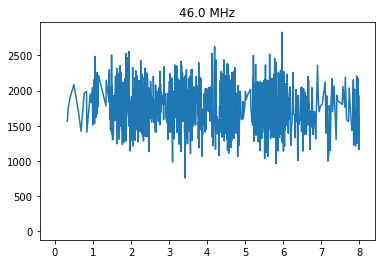

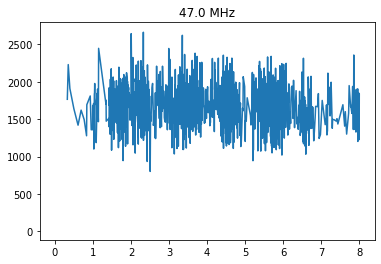

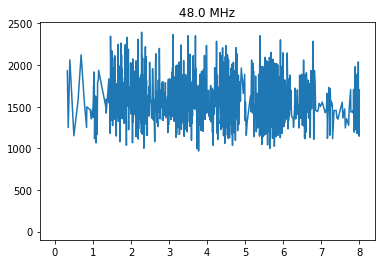

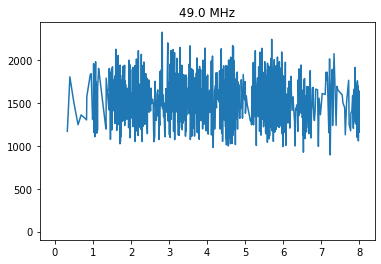

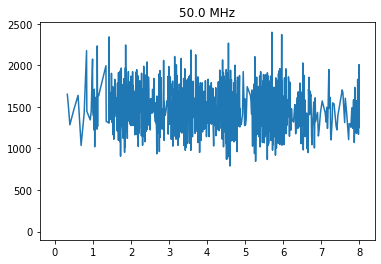

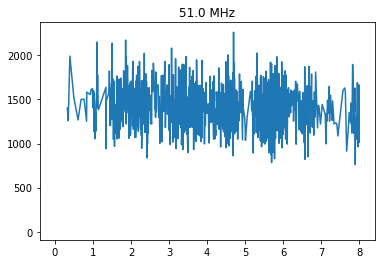

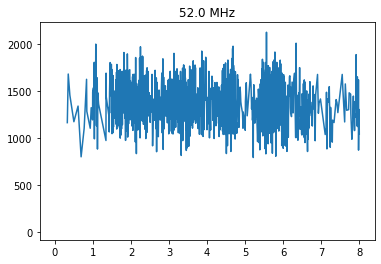

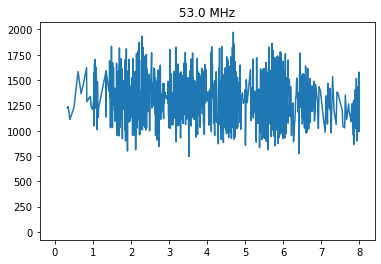

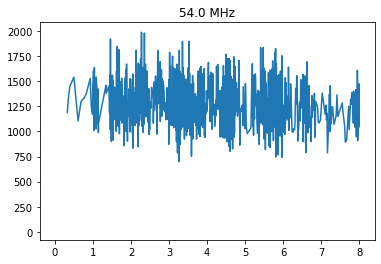

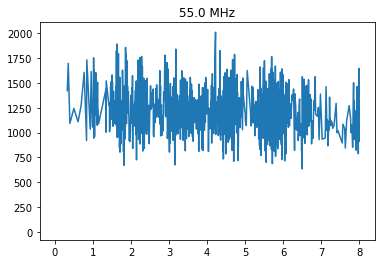

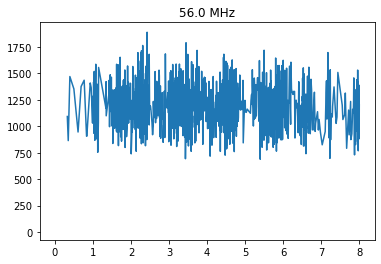

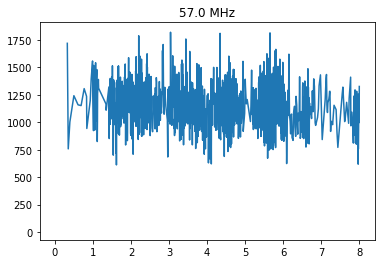

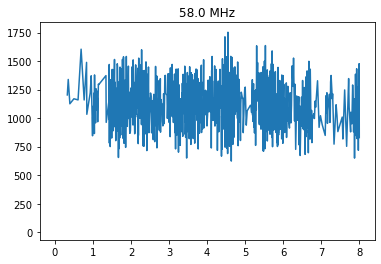

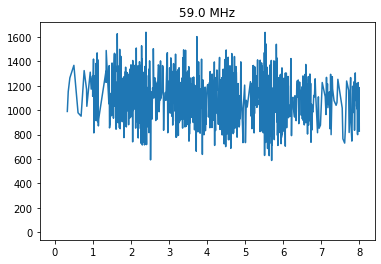

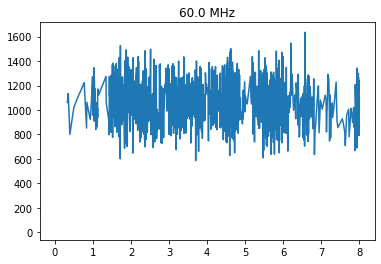

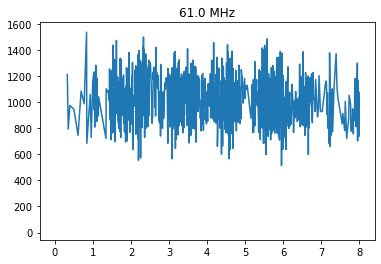

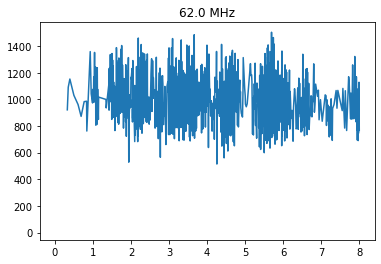

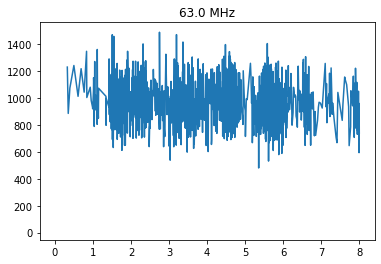

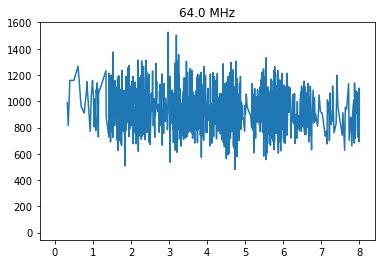

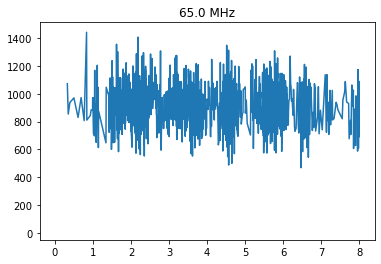

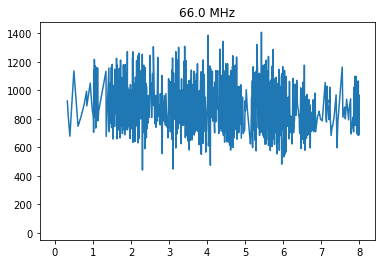

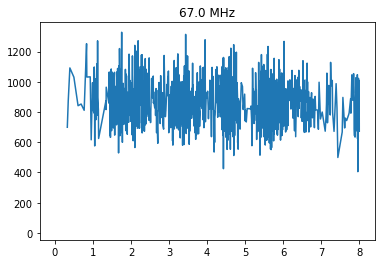

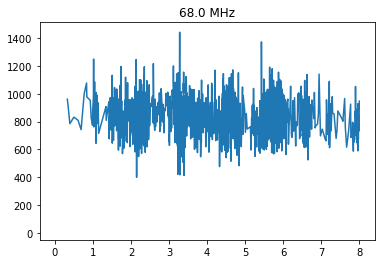

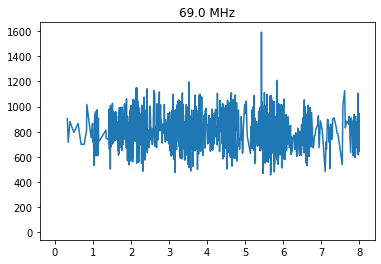

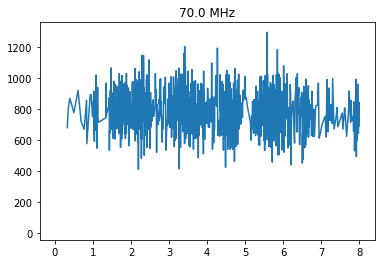

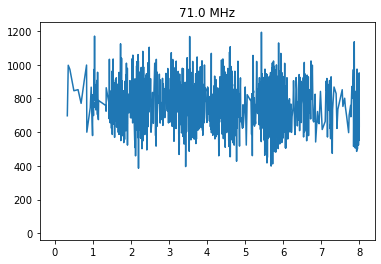

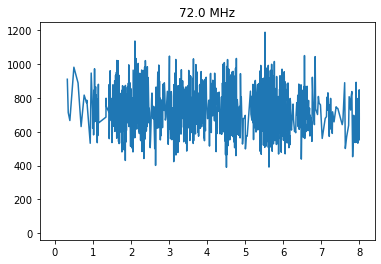

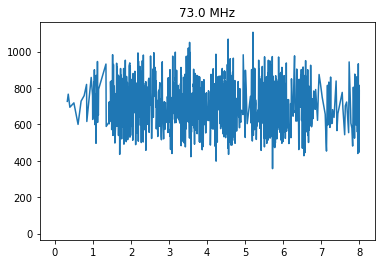

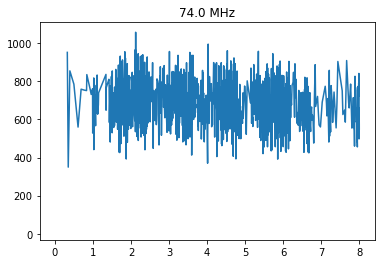

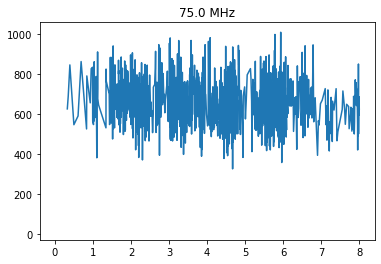

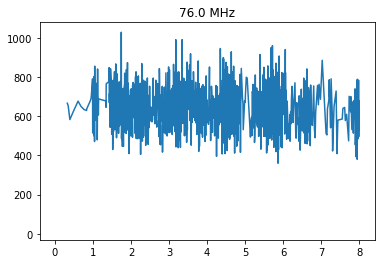

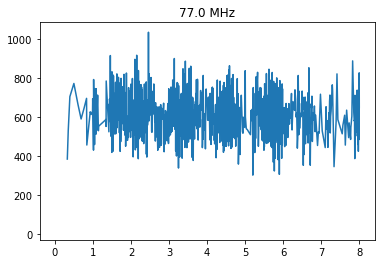

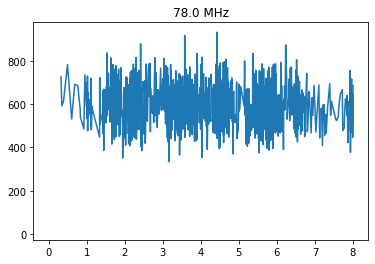

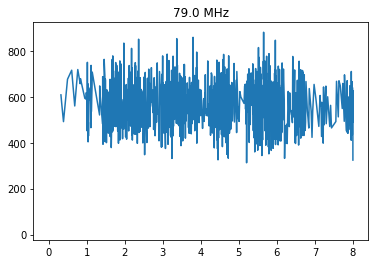

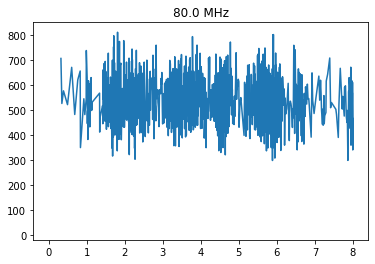

In [362]:
#look at that same distribution of the SQUARE ROOT of the power, in each channel, constrained to a narrower time window (so the galaxy won't have changed as much)
selectantennas=['LWA-010B']
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_indices=np.logical_and(lst_sorted,lst_sorted<8)
    lst_select=lst_sorted[lst_indices]
    spectra_select=spectra_ordered[lst_indices]

    for i,freq in enumerate(fnew):
        plt.figure()
        plt.title(str(freq)+' MHz')
        plt.plot(lst_select,np.sqrt(spectra_select[:,i]),20)

To do a least squares, I need an uncertainty estimate.  
I calculate this per frequency but not per time.  The power spectral density in a given channel should vary by a factor of two over a sidereal day, by at most about 10% in an hour.  The uncertainty in the power will be proportional to the power, but the component of the uncertainty due to this factor of two in power will be small, and I intend to ultimately use a monte carlo approach to finding the uncertainty in the final gain.  Thus, I compute one uncertainty per frequency, using all the events in a half hour window of time.

I compute the uncertainty on the amplitude (sqrt(power)) because I intend to perform the least squares in amplitude space.

75
51


Text(0, 0.5, 'Uncertainty in amplitude spectral density')

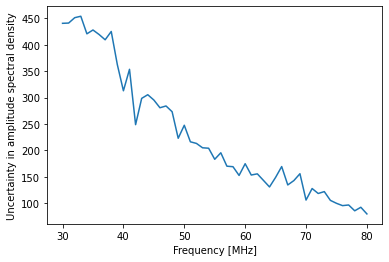

In [363]:
timerange_for_sigma=np.logical_and(lst_sorted>5,lst_sorted<5.5)
spectra_for_sigma=spectra_ordered[timerange_for_sigma]
amp_sigma=np.std(np.sqrt(spectra_for_sigma),0)

print(len(spectra_for_sigma))
print(len(amp_sigma))
plt.plot(fnew,amp_sigma)
plt.xlabel ('Frequency [MHz]')
plt.ylabel ('Uncertainty in amplitude spectral density')

## Per-frequency fit

In [377]:
#slope and intercept
def func(x,a,b):
    return a*x+b

model=np.zeros((len(fnew),len(lst_select)))
a=np.zeros(len(fnew)-1)
b=np.zeros(len(fnew)-1)
cov=[]

spectra_ordered_time_select=spectra_ordered[lst_sorted<8]
lst_select=lst_sorted[lst_sorted<8]

for i in range(len(fnew)-1):
    model[i,:]=np.interp(lst_select,lsts,modelEWarray[i,:])
    xdata=np.sqrt(model[i,:])
    ydata= spectra_ordered_time_select[:,i]
    sig=amp_sigma[i]*np.ones(len(ydata))
    popt, pcov = curve_fit(func, xdata, ydata,sigma=sig)
    a[i]=popt[0]
    b[i]=popt[1]
    cov.append(pcov)

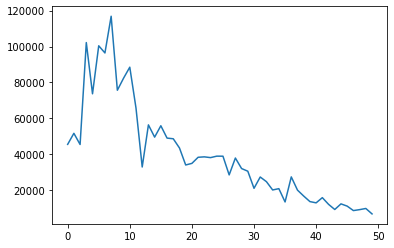

In [378]:
plt.plot(a)

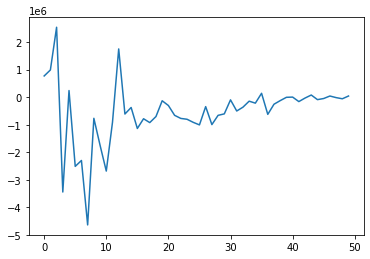

In [379]:
plt.plot(b)

In [492]:
def ampcal(frequenciesforfit,lstsforfit,powerspectraforfit,amp_sigma,lstsformodel,modelarray,scipycurvefit=False):
    
    #slope and intercept
    def func(x,a):
        return a*x

    model=np.zeros((len(frequenciesforfit),len(lstsforfit)))
    a=np.zeros(len(frequenciesforfit)-1)
    asig=np.zeros(len(frequenciesforfit)-1)
    chisq=np.zeros(len(frequenciesforfit)-1)

    for i in range(len(frequenciesforfit)-1):
        model[i,:]=np.interp(lstsforfit,lstsformodel,modelarray[i,:])
        xdata=np.sqrt(model[i,:])
        ydata= np.sqrt(powerspectraforfit[:,i])
        sig=amp_sigma[i]*np.ones(len(ydata))
        weights=sig**-2

        if 'scipycurvefit':
            popt, pcov = curve_fit(func, xdata, ydata,sigma=sig)
            a[i]=popt[0]
            asig[i]=pcov[0]**0.5

        else:
            a[i]=np.sum(xdata*ydata*weights)/np.sum(xdata*xdata*weights)
            asig[i]=np.sqrt(np.sum(xdata*xdata*weights))
    
    #report reduced chi squared value
        chisq[i]=np.sum(((ydata-(xdata*asig[i]))**2)*weights)/(len(xdata)-1)
    #print(len(xdata))
    return a,asig,chisq, model


In [527]:
modelshift=np.zeros(modelNSarray.shape)
spectrumdistortion=500*np.square(np.random.randn(modelNSarray.shape[0]))
for i in range(modelNSarray.shape[1]):
    modelshift[:,i]=spectrumdistortion

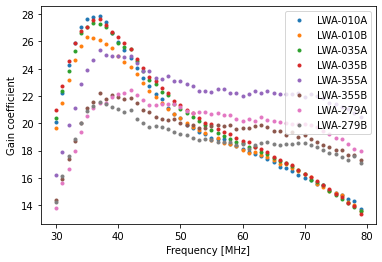

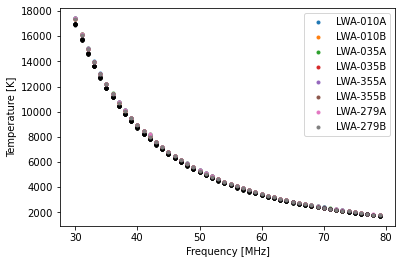

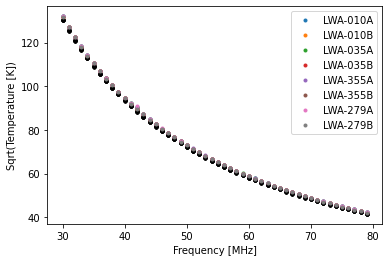

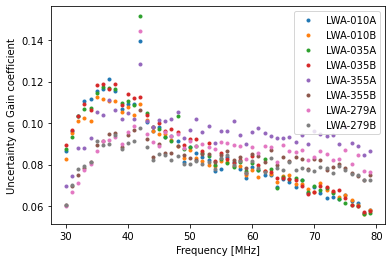

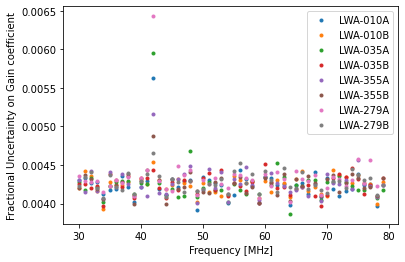

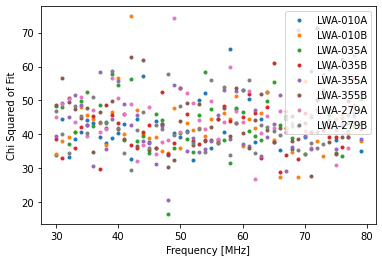

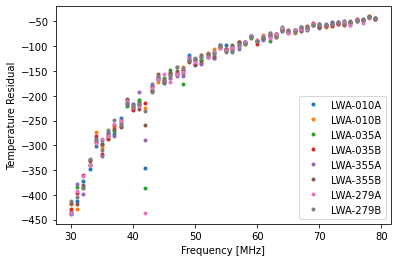

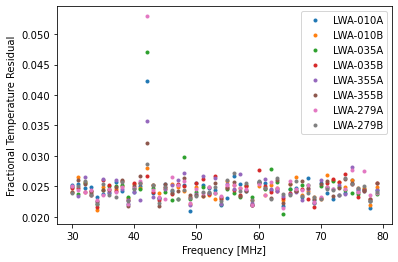

In [535]:
selectantennas=['LWA-010A','LWA-010B', 'LWA-035A','LWA-035B','LWA-355A','LWA-355B','LWA-279A','LWA-279B',]
for a in selectantennas:
    
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_indices=np.logical_and(lst_sorted,lst_sorted<8)
    lst_select=lst_sorted[lst_indices]
    spectra_select=spectra_ordered[lst_indices]

    #estimate uncertainties 
    timerange_for_sigma=np.logical_and(lst_sorted>5,lst_sorted<5.5)
    spectra_for_sigma=spectra_ordered[timerange_for_sigma]
    amp_sigma=np.std(np.sqrt(spectra_for_sigma),0)

    #do fit
    spectraforfit=spectra_ordered[lst_sorted<8]
    #spectraforfit=spectraforfit+0.5*np.mean(spectraforfit) #add a flat component
    lst_select=lst_sorted[lst_sorted<8]
    if a[-1]=='A':
        modelarray=modelNSarray#+modelshift
    elif a[-1]=='B':
        modelarray=modelEWarray#+modelshift
        
    antgain,gainsig,chisq,model=ampcal(fnew,lst_select,spectraforfit,amp_sigma,lsts,modelarray,scipycurvefit=True)
    
    #plot
    plt.figure(1)
    plt.plot(frequencies,antgain,'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Gain coefficient')
    plt.legend()
    
    plt.figure(2)
    plt.plot(frequencies,np.mean(model,1)[:-1],'k.')
    plt.plot(frequencies,(antgain**-2)*np.mean(spectraforfit,0)[:-1],'.',label=a)

    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Temperature [K]')
    plt.legend()
    
    plt.figure(3)
    plt.plot(frequencies,np.sqrt(np.mean(model,1))[:-1],'k.')
    plt.plot(frequencies,np.sqrt((antgain**-2)*np.mean(spectraforfit,0)[:-1]),'.',label=a)

    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Sqrt(Temperature [K])')
    plt.legend()
    
    plt.figure(4)
    plt.plot(frequencies,gainsig,'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Uncertainty on Gain coefficient')
    plt.legend()
    
    plt.figure(5)
    plt.plot(frequencies,gainsig/antgain,'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Fractional Uncertainty on Gain coefficient')
    plt.legend()
    
    plt.figure(6)
    plt.plot(frequencies,chisq,'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Chi Squared of Fit')
    plt.legend()
    
    plt.figure(7)
    plt.plot(frequencies,(np.mean(model,1)[:-1])-((antgain**-2)*np.mean(spectraforfit,0)[:-1]),'.',label=a)

    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Temperature Residual')
    plt.legend()
    
    plt.figure(8)
    d=((antgain**-2)*np.mean(spectraforfit,0)[:-1])
    m=(np.mean(model,1)[:-1])
    plt.plot(frequencies,(d-m)/d,'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Fractional Temperature Residual')
    plt.legend()

In [536]:
np.mean(spectraforfit)

2130033.966798817

### Do fit for all (non-flagged) antennas


In [539]:
ampcaltable={}
datatypes={'names':('gain','gainerr','frequency'),'formats':(np.single,np.single,np.single)}

nspecmin=1000 #minimum number of spectra to require
for a in specdictionary.keys():
    lst=specdictionary[a]['lst']
    spectra=specdictionary[a]['spec'] 
    sorted_indices=np.argsort(lst)
    spectra_ordered=spectra[sorted_indices]
    lst_sorted=lst[sorted_indices]
    lst_indices=np.logical_and(lst_sorted,lst_sorted<8)
    lst_select=lst_sorted[lst_indices]
    spectra_select=spectra_ordered[lst_indices]
    resultsarray=np.zeros(len(frequencies), dtype=datatypes)

    if spectra_select.shape[0] > nspecmin:
        #estimate uncertainties 
        timerange_for_sigma=np.logical_and(lst_sorted>5,lst_sorted<5.5)
        spectra_for_sigma=spectra_ordered[timerange_for_sigma]
        amp_sigma=np.std(np.sqrt(spectra_for_sigma),0)

        #do fit
        spectraforfit=spectra_ordered[lst_sorted<8]
        lst_select=lst_sorted[lst_sorted<8]
        if a[-1]=='A':
            modelarray=modelNSarray
        elif a[-1]=='B':
            modelarray=modelEWarray
        
        antgain,gainsig,chisq,model=ampcal(fnew,lst_select,spectraforfit,amp_sigma,lsts,modelNSarray,scipycurvefit=False)
        resultsarray['gain']=antgain
        resultsarray['gainerr']=gainsig
        resultsarray['frequency']=frequencies
    else:
        resultsarray['gain']=np.zeros(len(frequencies))
        resultsarray['gainerr']=np.zeros(len(frequencies))
        resultsarray['frequency']=np.zeros(len(frequencies))
    ampcaltable[a]=resultsarray

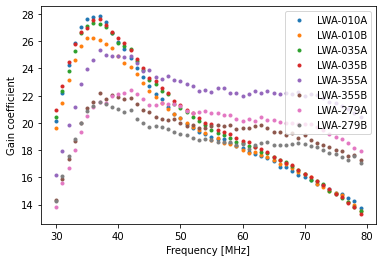

In [540]:
selectantennas=['LWA-010A','LWA-010B', 'LWA-035A','LWA-035B','LWA-355A','LWA-355B','LWA-279A','LWA-279B',]
for a in selectantennas:
    gainarray=ampcaltable[a]
    plt.plot(gainarray['frequency'],gainarray['gain'],'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Gain coefficient')
    plt.legend()

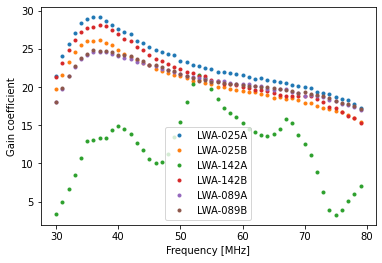

In [542]:
selectantennas=['LWA-025A','LWA-025B', 'LWA-142A','LWA-142B','LWA-089A','LWA-089B']
for a in selectantennas:
    gainarray=ampcaltable[a]
    plt.plot(gainarray['frequency'],gainarray['gain'],'.',label=a)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Gain coefficient')
    plt.legend()

/opt/devel/kplant/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


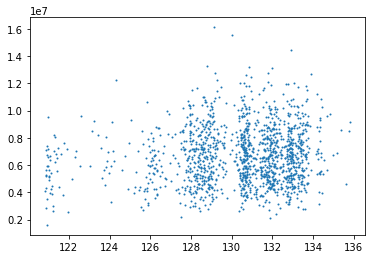

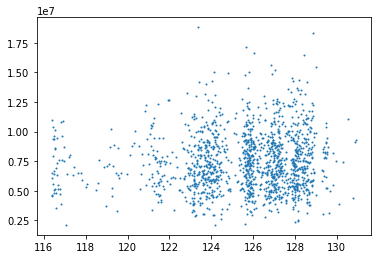

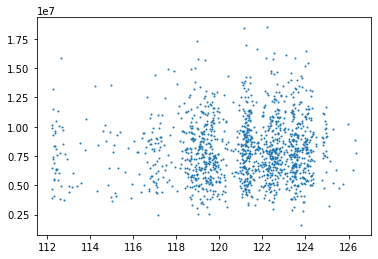

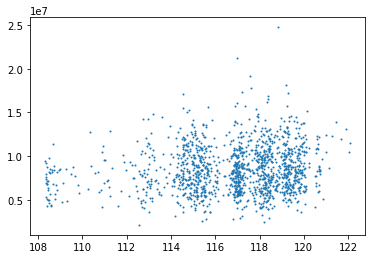

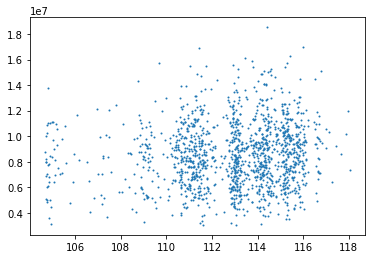

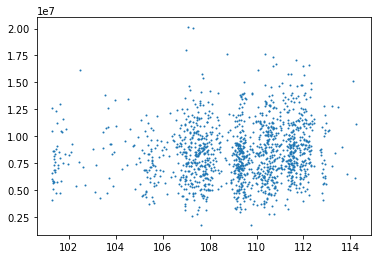

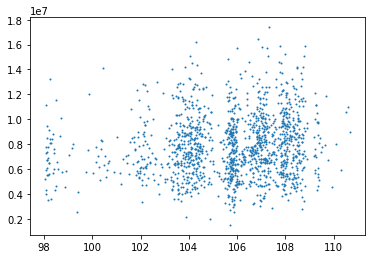

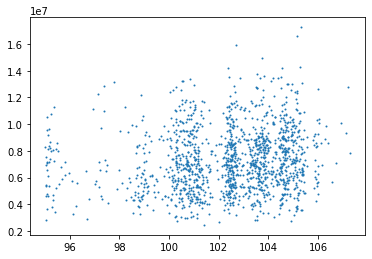

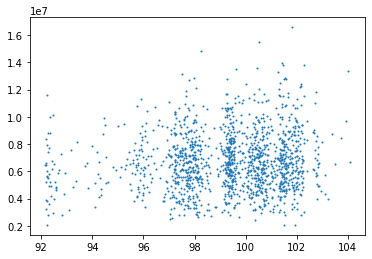

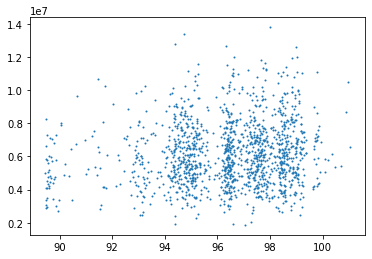

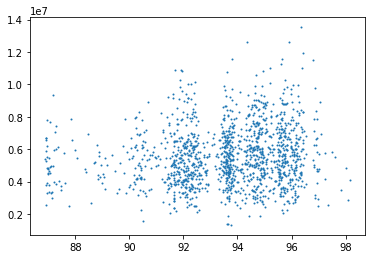

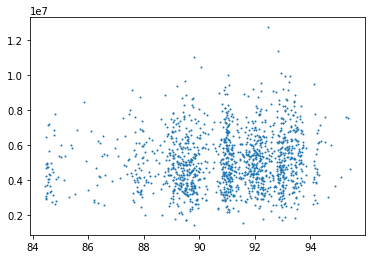

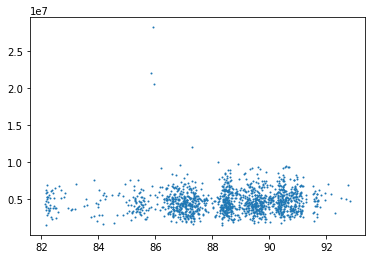

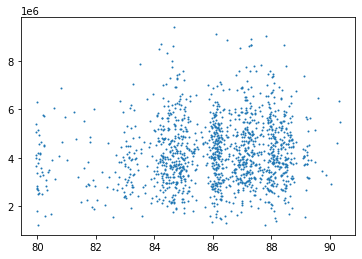

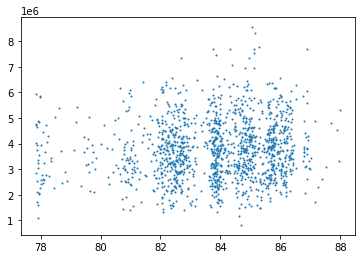

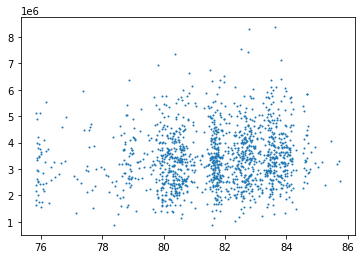

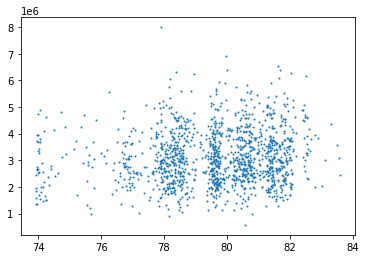

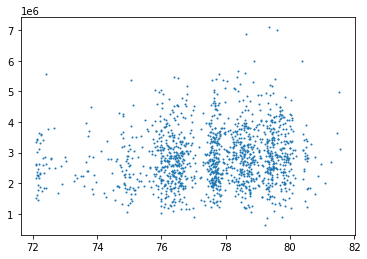

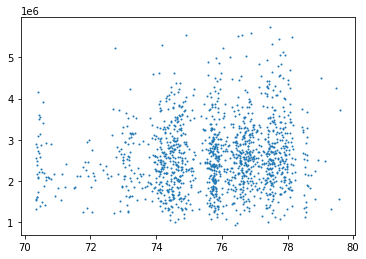

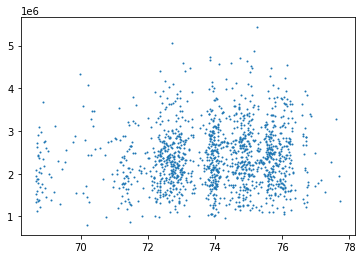

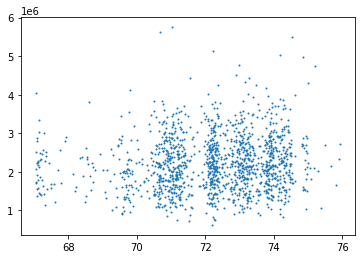

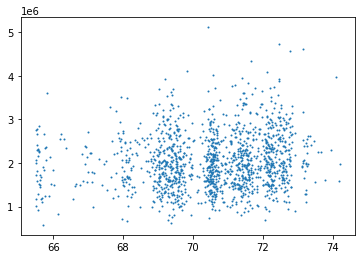

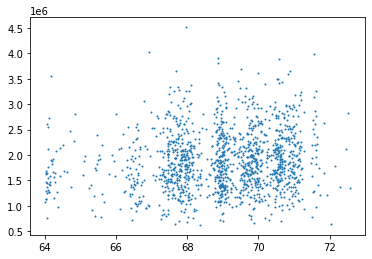

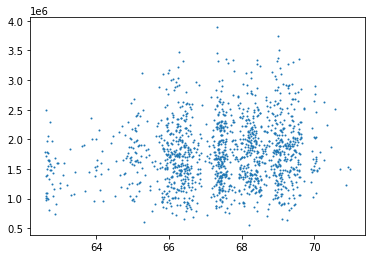

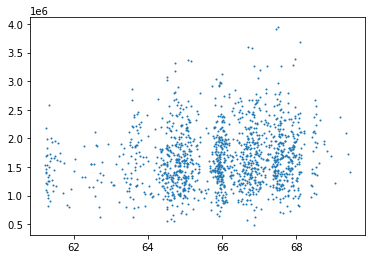

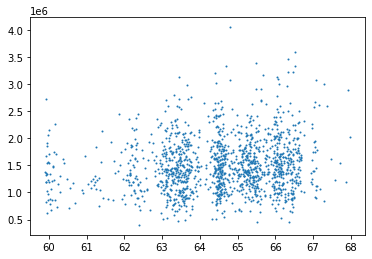

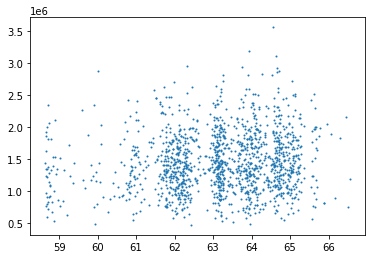

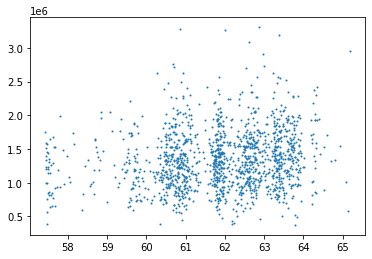

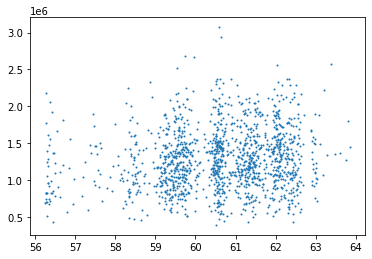

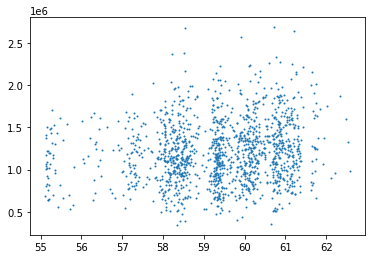

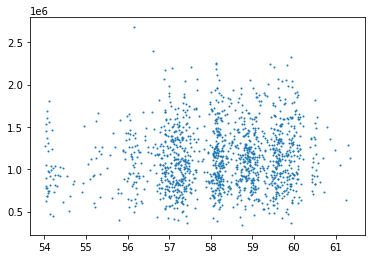

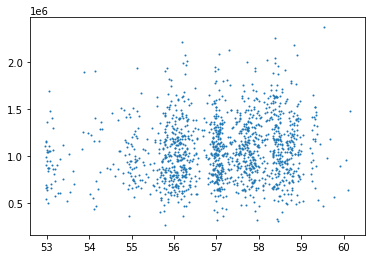

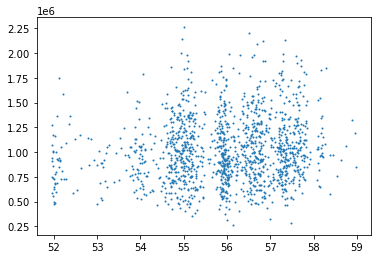

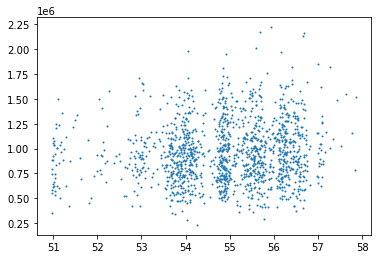

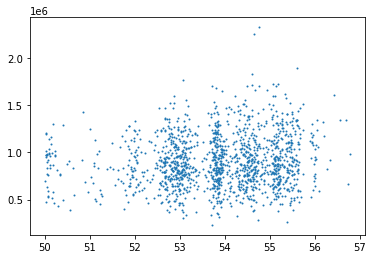

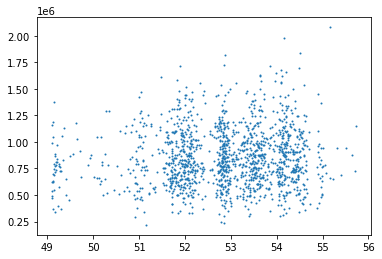

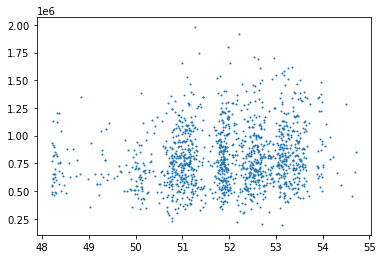

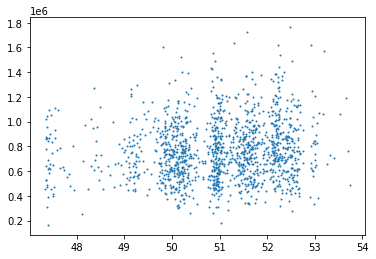

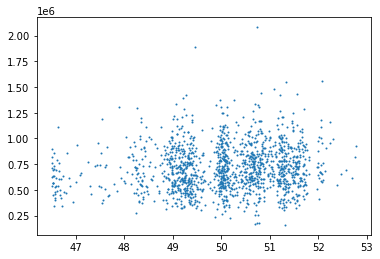

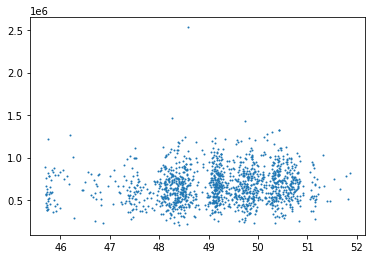

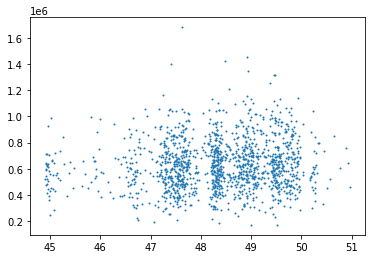

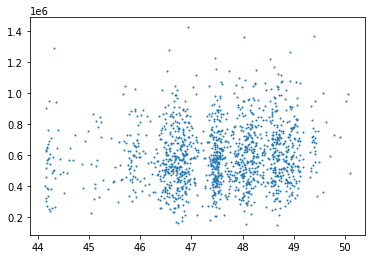

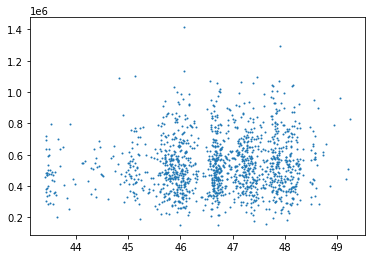

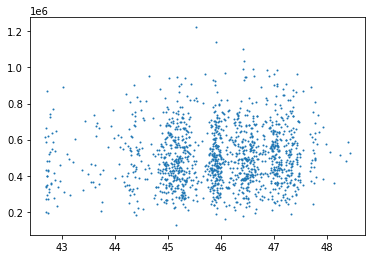

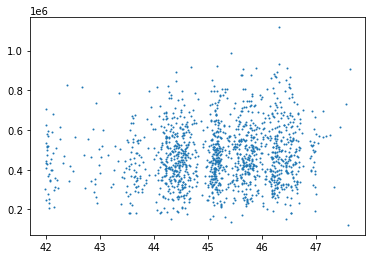

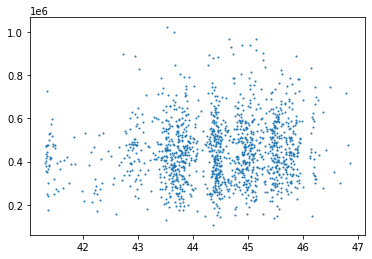

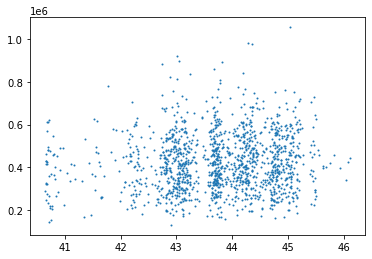

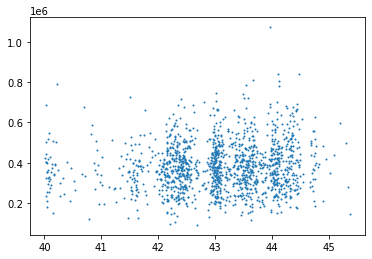

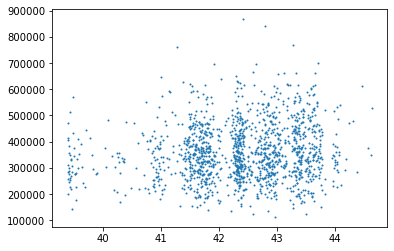

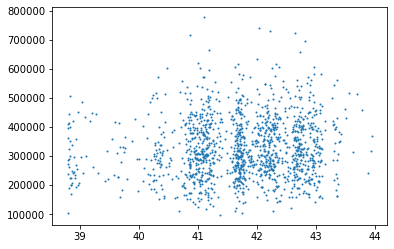

In [382]:
for i in range(len(frequencies)):
    plt.figure()
    plt.scatter(np.sqrt(model[i,:]),spectra_ordered_time_select[:,i],s=1)

## Plot expected impedance
Note that some more relevant 
Data from https://github.com/lwa-project/lsl_data/blob/main/antenna/BurnsZ.txt

In [370]:
impedance=np.loadtxt('dilullo_impedance_data.txt')

Text(0, 0.5, 'Re(Z)')

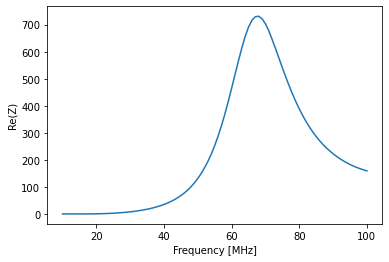

In [371]:
plt.plot(impedance[:,0],impedance[:,1])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Re(Z)')

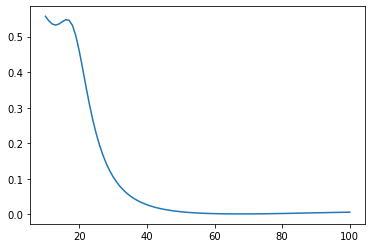

In [372]:
plt.plot(impedance[:,0],(impedance[:,1])**-1)

Text(0, 0.5, 'Im(Z)')

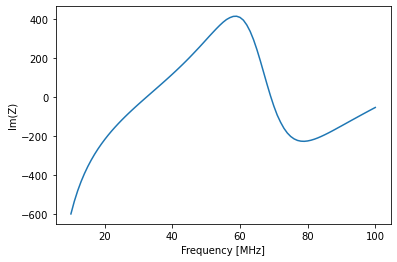

In [373]:
plt.plot(impedance[:,0],impedance[:,2])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Im(Z)')

Text(0, 0.5, '|Z|')

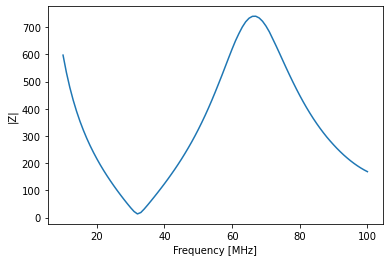

In [374]:
plt.plot(impedance[:,0],np.sqrt(impedance[:,1]**2+impedance[:,2]**2))
plt.xlabel('Frequency [MHz]')
plt.ylabel('|Z|')

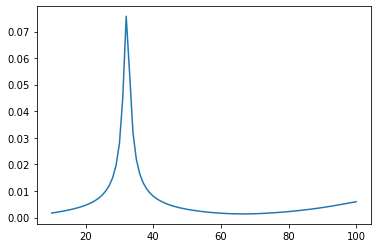

In [375]:
plt.plot(impedance[:,0],1/np.sqrt(impedance[:,1]**2+impedance[:,2]**2))

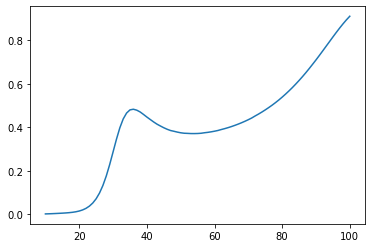

In [376]:
plt.plot(impedance[:,0],impedance[:,3])

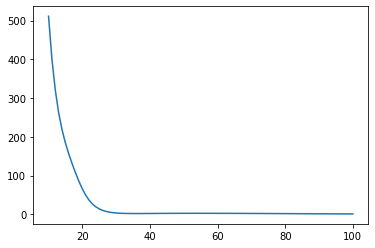

In [343]:
plt.plot(impedance[:,0],impedance[:,3]**-1)

# Apply calibration to one antenna time series